# LOAN APPROVAL CLASSIFICATION

## Business Understanding

In today's financial sector, lending institutions are facing increasing pressur to make accurate, data driven decisoons when approvil loans applications. This makes it vital to correctly distinguish creditworthy people from high-risk ones to maximize profitability and reduce the chances of loan defaults.

This project aims to build a model capable of evaluating the repayment likelihood of loans from an applicant’s demographic, financial and behavioral information. Thanks to  data science techniques, the model will privide actionable insights that will support lenders in the loan approval process and help them make more accurate decisions thus increasing the institution’s risk management framework.

## Project Objectives

**1. To examine demographic factors associated with high loan default rates**

**2. Determine whether there is a statistically significant relationship between an applicant's credit score and their loan approval status.**

**3. Build accurate models to predict whether a loan applicant will default on the loan.**

**4. Validate the model’s performance on unseen data to guarantee robustness and reliability in real-world applications.**

## Importing libraries

In [951]:
import pandas as pd
import math
import zipfile
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import (classification_report, accuracy_score,
                             roc_curve, auc, root_mean_squared_error, 
                             confusion_matrix, ConfusionMatrixDisplay,
                            precision_score, accuracy_score, f1_score)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, label_binarize, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

The data for this project was found on [Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data),aleading site for data science resources. The file contains detailed records loan applications which include personal information, details of a person’s finances and the current status of the loan. This dataset provides a solid foundation to develop a predictive models to assess credit risk effectively.

To begin, let's import the dataset:

In [539]:
# Extract the dataset from the archive_8 zipfile and save it as df
with zipfile.ZipFile('./Data/archive_8.zip') as z:
    with z.open('loan_data.csv') as f:
        df = pd.read_csv('loan_data.csv')

In [174]:
# Preview the first five records
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Next, let's create a function that provides an initial overview of the dataset and prints three key pieces of information:
1. `summary(dataframe)`
* Dataframe Shape - `df.shape`
* Dataframe info - `df.info()`
* Descriptive Statistics - `df.describe()`

In [571]:
# Create a function to display the dataframe's summary and descriptive statistics
def summary(dataframe):
    print('-------- Dataframe Shape -------\n')
    print(f'The dataframe has {df.shape[0]} rows and {df.shape[1]} columns\n')
    print('-------- Dataframe Info --------\n')
    print(df.info()) # dataframe summary
    print('\n')
    print('-------- Dataframe Descriptive Statistics --------\n')
    print(df.describe()) # dataframe descriptive statistics
    print('\n')

In [572]:
# Call out the summary function
summary(df)

-------- Dataframe Shape -------

The dataframe has 45000 rows and 14 columns

-------- Dataframe Info --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non

The dataset contains 45,000 rows and 14 columns, covering a range of features from personal to financial information.

Below is a **brief description** of each column:

| #  | Column                           | Description                                             | Type        |
|----|----------------------------------|---------------------------------------------------------|-------------|
| 1  | person_age                       | Age of the person                                       | Float       |
| 2  | person_gender                    | Gender of the person                                    | Categorical |
| 3  | person_education                 | Highest education level                                 | Categorical |
| 4  | person_income                    | Annual income                                           | Float       |
| 5  | person_emp_exp                   | Years of employment experience                          | Integer     |
| 6  | person_home_ownership            | Home ownership status (e.g., rent, own, mortgage)       | Categorical |
| 7  | loan_amnt                        | Loan amount requested                                   | Float       |
| 8  | loan_intent                      | Purpose of the loan                                     | Categorical |
| 9  | loan_int_rate                    | Loan interest rate                                      | Float       |
| 10 | loan_percent_income              | Loan as a percentage of annual income                   | Float       |
| 11 | cb_person_cred_hist_length       | Length of credit history in years                       | Float       |
| 12 | credit_score                     | Credit score of the person                              | Integer     |
| 13 | previous_loan_defaults_on_file   | Indicator of previous loan defaults                     | Categorical |
| 14 | loan_status (target variable)    | Loan approval status: 1 = approved; 0 = rejected        | Integer     |



After getting a layout of how the data looks like, the next step is to get an understanding of how each numerical variable behaves for different classes of the target variable `loan_status`. This will help identify the variables' **distribution, potential patterns** and **important features** that could contribute to a model. This will be done using a Kernel Distribution plot (KDE).

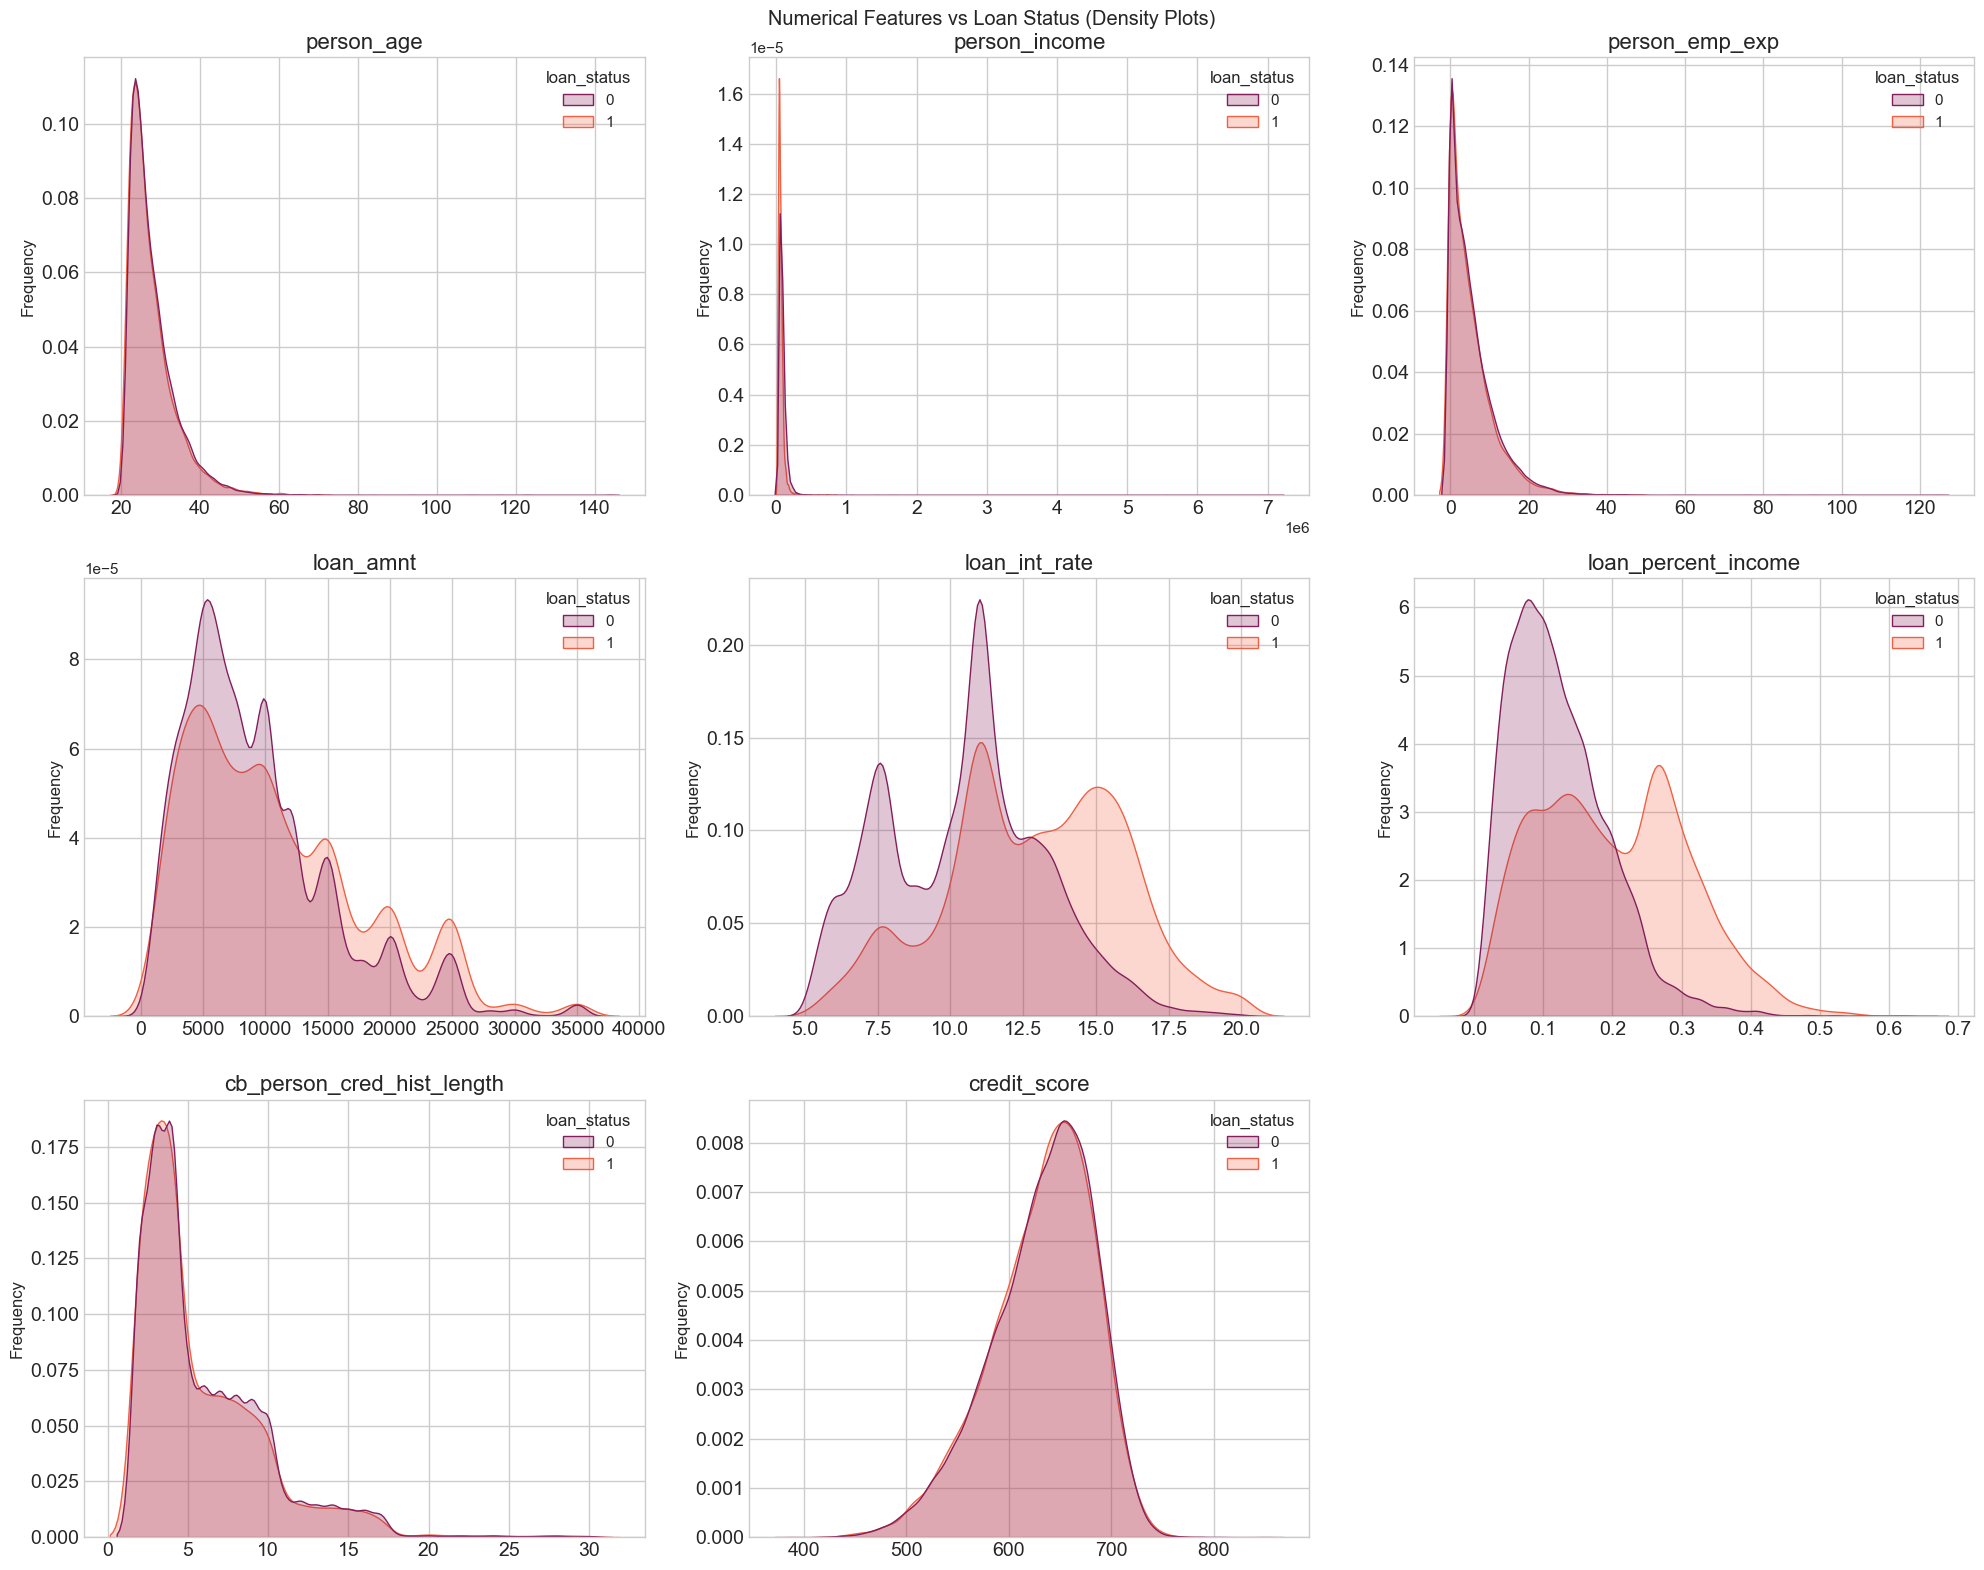

In [575]:
# Select all columns with numeric data types (int or float)
numerical_cols = df.select_dtypes('number').columns

# Set seaborn plot style to 'whitegrid' for a cleaner background
sns.set_style('whitegrid')

# Create a figure with 3 rows and 3 columns of subplots (to fit 9 numerical features)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16))

# Add a super title for the entire figure
fig.suptitle('Numerical Features vs Loan Status (Density Plots)')

# Flatten the 2D array of axes to make iteration easier
axes = axes.flatten()

# Loop over all numerical columns and plot each one
for i, col in enumerate(numerical_cols): 
    sns.kdeplot(
        x=col,              
        data=df,             
        ax=axes[i],          
        hue='loan_status',   
        fill=True,     
        common_norm=False,  
        palette='rocket'    
    )
    
    axes[i].set_title(col, fontsize=16)        # Set plot title to the column name
    axes[i].set_xlabel('', fontsize=12)        # Remove x-axis label for clean visuals
    axes[i].set_ylabel('Frequency', fontsize=12)  # Label y-axis as Frequency
    axes[i].tick_params(axis='x', labelsize=14)   # Adjust font size for x-axis ticks
    axes[i].tick_params(axis='y', labelsize=14)   # Adjust font size for y-axis ticks

# Remove any empty/unfilled subplots (if there are fewer features than subplots)
for j in range(len(numerical_cols) - 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between plots to avoid overlap
plt.tight_layout()

# Display the complete figure with all subplots
plt.show()


From the above visualization, we can already derive a lot of information about the different features and their relationship with the target variable `loan_status`. Key notable takeaways from this visualization are:

* `person_age` column has a distribution that is right-skewed. Most applicants are between the age of 25–35.

* `person_income` column is extremely right-skewed probably due to outliers

* `person_emp_exp column` is also right-skewed. It brings to light that most applicants have 0–20 years of experience.

* `loan_amnt` columns shows that more lower amount loans are rejected. Most applicants seems to apply loans between 2500 to 10,000

* `loan_int_rate` column is a strong indicator with rejected loans (0) clustering at higher interest rates. Approved loans (1) have peaks at lower interest rates (around 11%). This seems to be a **good potential predictor**.

* `loan_percent_income` column is a also a **very useful feature**. Approved loans tend to have lower loan-to-income ratios while rejections increase as the ratio increases.

* `cb_person_cred_hist_length` brings to light that most applicants have credit histories between 0 - 5 years. The curves mostly overlap. This is a **weak indicator**.

* `credit_score` column appears normally distributed with the two curves overlapping perfectly. This also seems to be a **weak indicator**.

Similar to the numerical columns, let's get a clear view of the value counts for each categorical feature. This will help in detecting imbalanced categories and understand the dominant classes. 

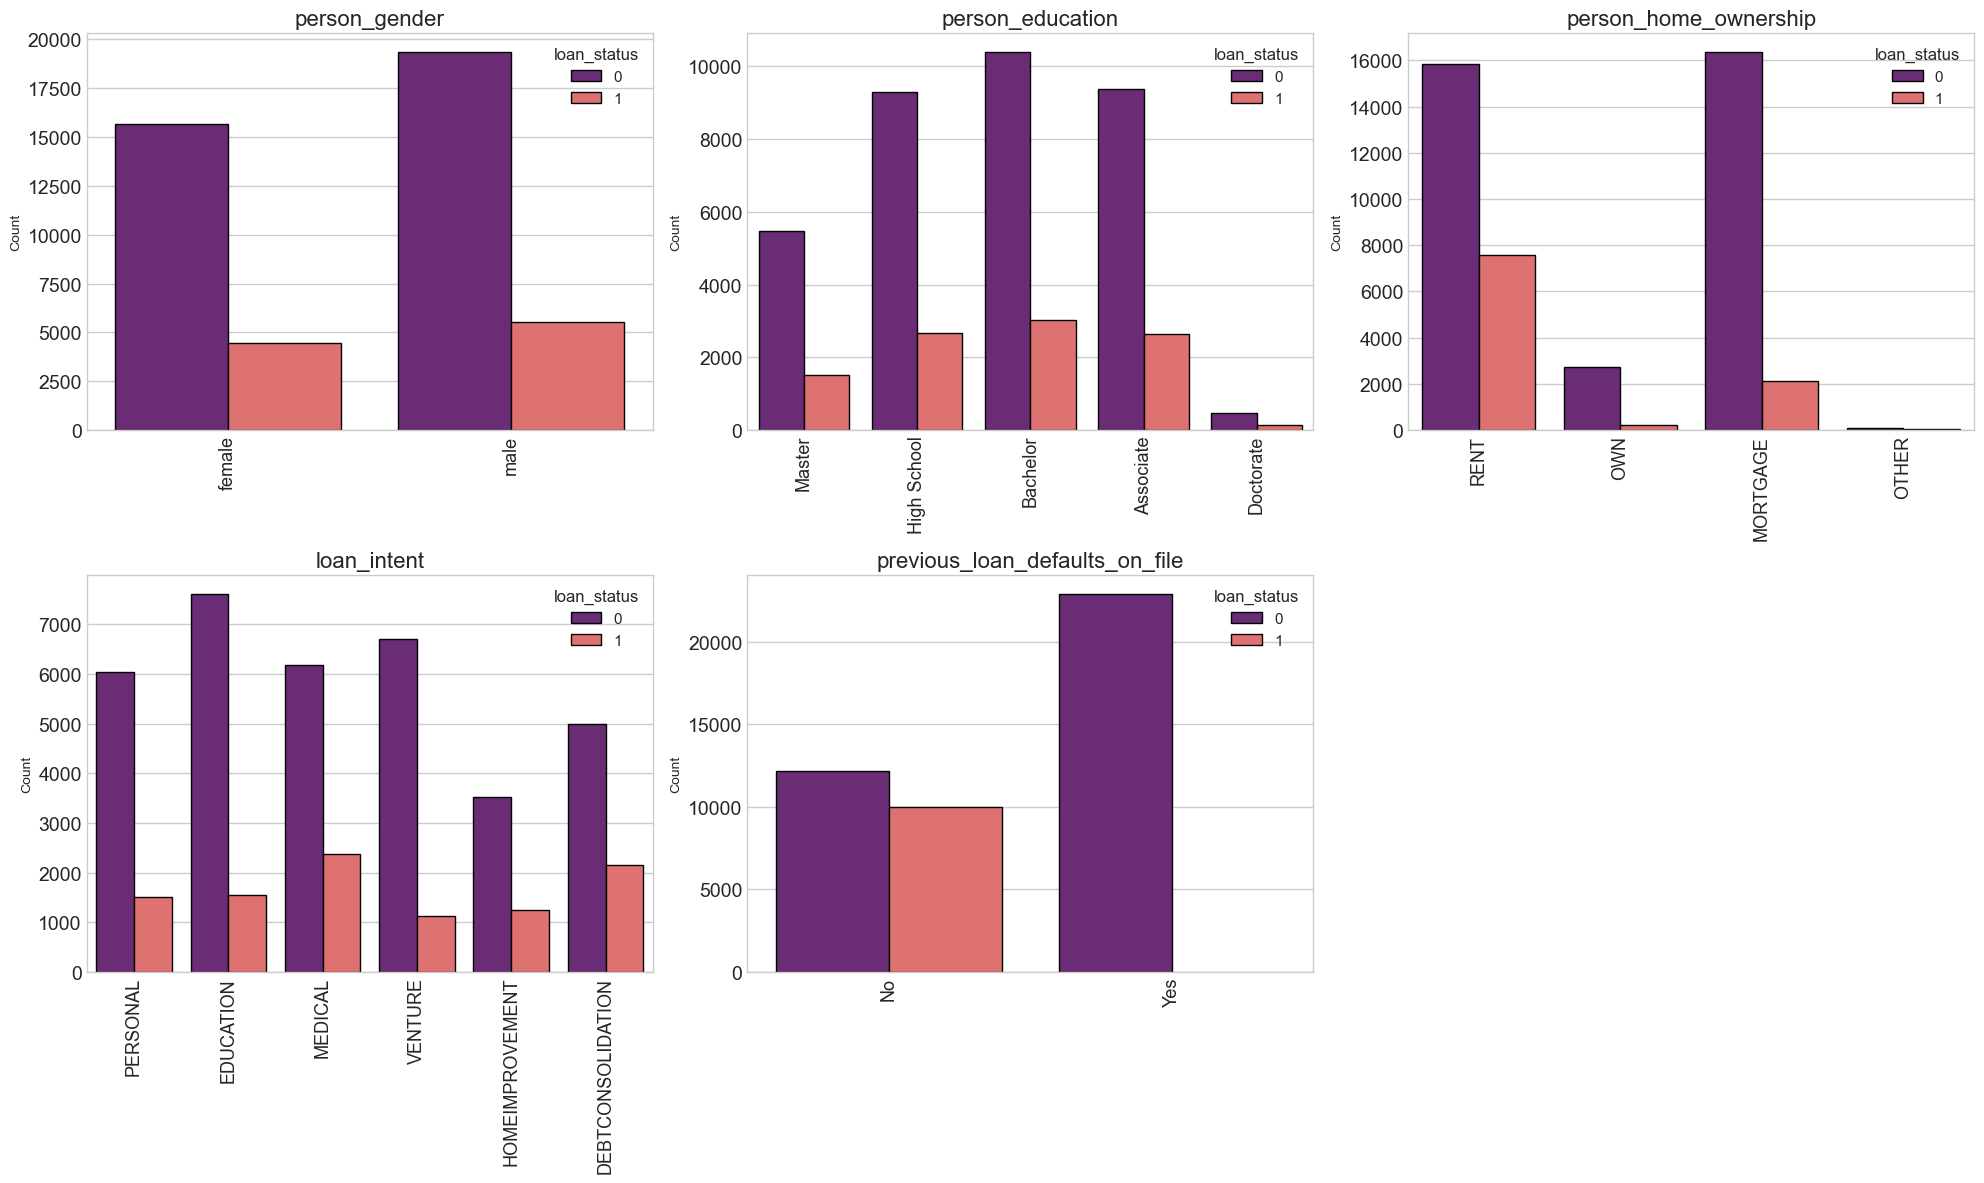

In [578]:
# Step 1: Identify all categorical columns (e.g., object or category data types)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Step 2: Set Seaborn style to white grid for better aesthetics
sns.set_style('whitegrid')

# Step 3: Create a 2-row by 3-column grid of subplots (can show up to 6 plots)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Step 4: Flatten the 2D subplot array into a 1D list for easier looping
axes = axes.flatten()

# Step 5: Loop through each categorical column to plot its value counts
for i, col in enumerate(categorical_cols):
    sns.countplot(
        data=df,         # Data source
        x=col, 
        hue='loan_status', # Column to be plotted on the x-axis
        ax=axes[i],      # Assign each plot to one subplot axis
        edgecolor='black',     # Add black borders to bars
        palette='magma'        # Use a visually appealing color palette
    )
    
    axes[i].set_title(col, fontsize=16)               # Set the title of the subplot
    axes[i].set_xlabel('')                            # Optionally remove x-axis label for cleaner look
    axes[i].set_ylabel('Count', fontsize=10)          # Set y-axis label
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=13)  # Rotate x labels for better readability
    axes[i].tick_params(axis='y', labelsize=14)       # Set font size of y-axis ticks

# Step 6: If fewer plots than axes, delete the unused subplot(s)
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

# Step 7: Adjust spacing between plots and display the figure
plt.tight_layout()
plt.show()


From this visualization, the key notable takeaways are:
* From the `person_gender` feature, the data shows that the male gender has the highest loan rejections and loan approvals. This indicates that more males apply for loans increasing their chances of getting approved or rejected. This doesn't necessarily imply gender-based bias in approval.
* In the `person_education` column, the data shows that the Doctorate degree holders have the lowest loan applications. This could be due to the fact that Doctorate degree holders make up a small portion of the population or they are financially stable and don't require loans.
* The `previous_loan_defaults_on_file` feature is probably **the strongest predictor** as no person who had a previous loan default got a loan approval.

## Data Preparation

The data preparation step aims to prepare the data for modelling and visualization. Key steps include normalizing the data, splitting the data into train and testing data to prevent data leakage, categorical encoding andchecking for multicollinearity.

### Data Splitting

Data splitting is a crucial step in building a reliable and unbiased prediction model. It involves dividing the data into training and testing datasets - one for training the model and one for validating the dataset. Splitting ensures that the model is tested on data it hasn't interacted with before. This will simulate how it will perform in the real world.

In [8]:
# Separate the features (X) and the target variable (y) from the dataframe
X = df.drop('loan_status', axis=1)  
y = df['loan_status']               

# Split the dataset into training and testing sets
# 80% of data goes to training, 20% to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train back into a single DataFrame for easier handling of training data
train_df = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test back into a single DataFrame for easier handling of testing data
test_df = pd.concat([X_test, y_test], axis=1)


### Data Cleaning

To handle missing and duplicate values, let's create a function that outputs:
* Missing values - `df.isna().sum()`
* Duplicate values - `df.duplicated().value_counts()`

In [580]:
# Create a function to display the dataframe's missing and duplicate values
def discrepancies(dataframe):
    print('-------- DataFrame Missing Values --------\n')
    print(df.isna().sum()) # Check for missing values
    print('\n')
    print('-------- Dataframe Duplicate Values --------\n')
    print(df.duplicated().value_counts()) # Check for duplicate values

In [12]:
discrepancies(train_df)

-------- DataFrame Missing Values --------
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


-------- Dataframe Duplicate Values --------
False    45000
Name: count, dtype: int64


The dataframe has no missing and duplicate values. Next, let's validate the contents of the categorical columns for any discrepancies such as placeholders or characters.

In [582]:
# Identify categorical columns in the training dataset
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column and display value counts
for col in categorical_cols:
    print(f"\n--- Value counts for column: {col} ---")
    print(train_df[col].value_counts())


--- Value counts for column: person_gender ---
person_gender
male      19817
female    16183
Name: count, dtype: int64

--- Value counts for column: person_education ---
person_education
Bachelor       10772
Associate       9607
High School     9508
Master          5609
Doctorate        504
Name: count, dtype: int64

--- Value counts for column: person_home_ownership ---
person_home_ownership
RENT        18727
MORTGAGE    14795
OWN          2379
OTHER          99
Name: count, dtype: int64

--- Value counts for column: loan_intent ---
loan_intent
EDUCATION            7381
MEDICAL              6818
VENTURE              6227
PERSONAL             6030
DEBTCONSOLIDATION    5731
HOMEIMPROVEMENT      3813
Name: count, dtype: int64

--- Value counts for column: previous_loan_defaults_on_file ---
previous_loan_defaults_on_file
Yes    18253
No     17747
Name: count, dtype: int64


The columns have their perceived values and there doesn't seem to be presence of placeholders or unknown characters.

### Scaling

Scaling will transform features by scaling them to a given range (Usually [0,1] with minmax scaling). This is important as it scales all the numerical features to the same scale. Minmax scaling is preferred as it does not distort the shape of the original distribution. This is good for data visualization.

To ease the process, it will be best to create two almost similar features; one for the training data that outputs the scaled dataframe and the fitted scaler, and one for the testing data that takes in both the dataframe to be scaled and the pre fitted scaler to apply the same transformation.

In [500]:
def fit_scaler_on_train(train_df):
    """
    Fits a MinMaxScaler on the numeric columns of training data.
    Returns the fitted scaler and the scaled training data.
    """
    # Select numeric columns to scale
    numeric_cols = train_df.select_dtypes(include='number').columns

    # Select categorical columns to preserve (they won't be scaled)
    categorical_cols = train_df.select_dtypes('object')

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on training numeric data and transform it
    scaled_train = scaler.fit_transform(train_df[numeric_cols])

    # Create a new DataFrame from the scaled numeric data, keeping original column names and indices
    scaled_train_df = pd.DataFrame(scaled_train, columns=numeric_cols, index=train_df.index)

    # Concatenate the unscaled categorical columns with the scaled numeric columns
    concated_df = pd.concat([categorical_cols, scaled_train_df], axis=1)

    # Return both the fitted scaler and the transformed training DataFrame
    return scaler, concated_df


def apply_scaler_on_test(test_df, scaler):
    """
    Applies an existing fitted scaler to numeric columns of test data.
    Returns a scaled test DataFrame.
    """
    # Select numeric columns to scale
    numeric_cols = test_df.select_dtypes(include='number').columns

    # Select categorical columns to preserve
    categorical_cols = test_df.select_dtypes('object')

    # Apply the previously fitted scaler to the numeric test data
    scaled_test = scaler.transform(test_df[numeric_cols])

    # Create a new DataFrame from the scaled numeric data
    scaled_test_df = pd.DataFrame(scaled_test, columns=numeric_cols, index=test_df.index)

    # Concatenate the unscaled categorical columns with the scaled numeric columns
    concated_df = pd.concat([categorical_cols, scaled_test_df], axis=1)

    # Return the fully prepared (scaled + categorical) test DataFrame
    return concated_df


In [501]:
# Transform the training data and preserve the scaler for the testing dataset
scaler, scaled_df = fit_scaler_on_train(train_df)
# Preview the results
scaled_df.head()

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
25180,female,Bachelor,MORTGAGE,PERSONAL,No,0.112903,0.012410,0.088,0.420290,0.501372,0.238095,0.250000,0.523913,0.0
12555,male,High School,RENT,VENTURE,Yes,0.040323,0.009030,0.024,0.333333,0.441701,0.253968,0.071429,0.584783,0.0
29153,female,Master,MORTGAGE,PERSONAL,Yes,0.169355,0.043738,0.144,0.681159,0.339506,0.111111,0.321429,0.636957,0.0
23838,male,Associate,RENT,EDUCATION,No,0.056452,0.011989,0.032,0.263768,0.803841,0.158730,0.178571,0.545652,0.0
35686,male,Master,RENT,HOMEIMPROVEMENT,Yes,0.056452,0.010688,0.056,0.190116,0.517833,0.126984,0.035714,0.686957,0.0


### Encoding

The aim of encoding is to convert categorical data into numerical format which is necessary because most machine learning models require numerical input.
Let's check the values in the categorical columns in order to figure out which type of encoder to use.

In [585]:
# Loop through each categorical column and display value counts
for col in categorical_cols:
    print(f"\n--- Value counts for column: {col} ---")
    print(train_df[col].value_counts())


--- Value counts for column: person_gender ---
person_gender
male      19817
female    16183
Name: count, dtype: int64

--- Value counts for column: person_education ---
person_education
Bachelor       10772
Associate       9607
High School     9508
Master          5609
Doctorate        504
Name: count, dtype: int64

--- Value counts for column: person_home_ownership ---
person_home_ownership
RENT        18727
MORTGAGE    14795
OWN          2379
OTHER          99
Name: count, dtype: int64

--- Value counts for column: loan_intent ---
loan_intent
EDUCATION            7381
MEDICAL              6818
VENTURE              6227
PERSONAL             6030
DEBTCONSOLIDATION    5731
HOMEIMPROVEMENT      3813
Name: count, dtype: int64

--- Value counts for column: previous_loan_defaults_on_file ---
previous_loan_defaults_on_file
Yes    18253
No     17747
Name: count, dtype: int64


`previous_loan_defaults_on_file`, `person_home_ownership`, `person_gender`, `loan_intent` columns will require one-hot encoding since the values don't possess any hierarchy or rank. The `person_education` column contains information about the level of education of the applicants and as such, it will require ordinal encoding.

Let's create a function that will be used on both training and testing data for encoding.

In [591]:
# Create a function to be used by both the training and testing data for encoding
def encode_df(df):
    """
    Encodes categorical features in the input DataFrame using:
    - Ordinal encoding for 'person_education'
    - One-hot encoding for selected nominal features
    Returns the encoded DataFrame.
    """
    
    # Make a copy to avoid modifying the original DataFrame
    df_encoded = df.copy()

    # --- Ordinal Encoding ---
    # Define the order for the 'person_education' column
    education_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]
    
    # Check if the column exists before encoding
    if 'person_education' in df_encoded.columns:
        # Create and fit an OrdinalEncoder with the specified order
        ord_enc = OrdinalEncoder(categories=education_order)
        
        # Transform the 'person_education' column and add it as a new feature
        df_encoded['person_education_encoded'] = ord_enc.fit_transform(df_encoded[['person_education']])
                

    # --- One-Hot Encoding ---
    # Columns to be one-hot encoded (nominal categories, no inherent order)
    onehot_cols = [
        'person_gender',
        'person_home_ownership',
        'loan_intent',
        'previous_loan_defaults_on_file'
    ]

    for col in onehot_cols:
        if col in df_encoded.columns:
            # Create OneHotEncoder instance
            ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
            
            # Fit and transform the column
            transformed = ohe.fit_transform(df_encoded[[col]])
            
            # Get new column names for the encoded variables
            col_names = ohe.get_feature_names_out([col])
            
            # Create a DataFrame from the transformed output
            onehot_df = pd.DataFrame(transformed, columns=col_names, index=df_encoded.index)
            
            # Concatenate the one-hot encoded columns with the original DataFrame
            df_encoded = pd.concat([df_encoded, onehot_df], axis=1)

    # Return the fully encoded DataFrame
    return df_encoded

In [592]:
# Create a function for easier dropping of the categorical columns that were encoded
def drop_columns(df):
    
    # A list of columns to drop
    columns_to_drop = [
        'person_gender', 'person_education',
        'person_home_ownership', 'age_bin',
        'loan_intent','Loan_Status_Encoded',
        'previous_loan_defaults_on_file'
    ]
  
    return df.drop(columns=columns_to_drop, errors='ignore')


In [593]:
# Apply the function on the scaled dataframe
encoded_df = encode_df(scaled_df)
# Create a df with the dropped categorical columns
num_df = drop_columns(encoded_df)

We will also need a second dataframe with the categorical columns for visualization. In this case we will use the initial training dataframe that hasn't been normalized for better visualizations.

In [588]:
# Create a copy of the training df for visualization
eda_df = train_df.copy()
# Encode the target variable for easier visualization
eda_df['Loan_Status_Encoded'] = eda_df['loan_status'].map({1: 'Approved', 0: 'Rejected'})

In [589]:
# Preview the dataframe
eda_df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,Loan_Status_Encoded
25180,34.0,female,Bachelor,97265.0,11,MORTGAGE,15000.0,PERSONAL,12.73,0.15,9.0,631,No,0,Rejected
12555,25.0,male,High School,72953.0,3,RENT,12000.0,VENTURE,11.86,0.16,4.0,659,Yes,0,Rejected
29153,41.0,female,Master,322597.0,18,MORTGAGE,24000.0,PERSONAL,10.37,0.07,11.0,683,Yes,0,Rejected
23838,27.0,male,Associate,94232.0,4,RENT,9600.0,EDUCATION,17.14,0.10,7.0,641,No,0,Rejected
35686,27.0,male,Master,84873.0,7,RENT,7059.0,HOMEIMPROVEMENT,12.97,0.08,3.0,706,Yes,0,Rejected


### Multicollinearity Check

Multicollinearity occurs when two or more independent variables are **highly correlated** with each other. This can cause models to fit the noise rather than the signal espesially in models such as logistic regression. Multicollinearity also causes redundancy and removing features that are highly correlated increases the model performance.

In [594]:
# Loop through each column in the numeric DataFrame
for index, col in enumerate(num_df.columns):
    
    # Check if the corresponding column in correlation_df is of type 'object' (i.e., categorical)
    if correlation_df[col].dtypes == 'object':
        print(col, 'Column has categorical values')
    
    # If this is the last column in the loop and no categorical column was found earlier print no columns were found to be categorical
    elif index + 1 == len(correlation_df.columns):
        print('There are no columns with categorical values')


There are no columns with categorical values


Now that we have affirmed that there are no categorical columns in the dataframe, let's create a heatmap visualizing the level of correlation between the different columns.

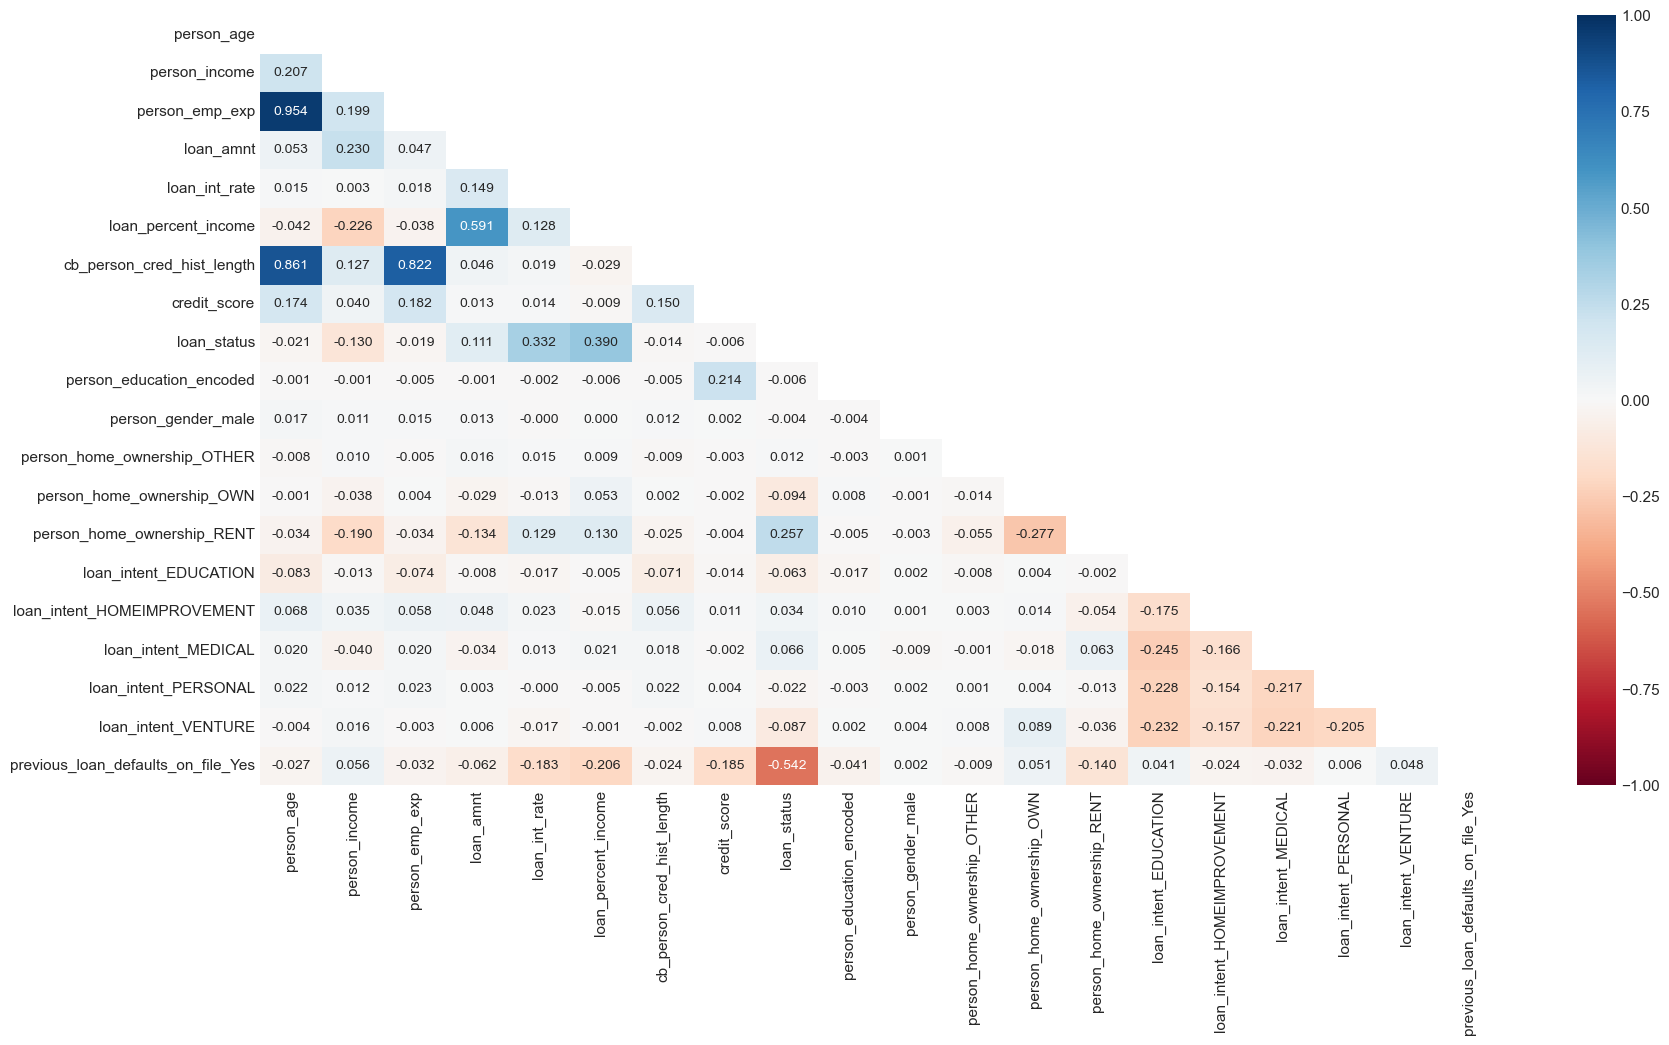

In [601]:
# Calculate the correlation matrix for numeric columns in the DataFrame
correlation_matrix = num_df.corr()

# Create a mask for the upper triangle of the matrix
# This avoids showing duplicate correlations since the matrix is symmetric
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the figure size for better readability
plt.figure(figsize=(20, 10))
sns.set_style('white')

# Plot a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, mask=mask, # - mask applies the upper triangle mask, hiding redundant info
            annot=True, fmt=".3f", #formats the annotations to 3 decimal places
            annot_kws={"fontsize": 10}, # set the font size of the annotations
            cmap="RdBu", vmin=-1, vmax=1) # set the color scale range from -1 (perfect negative) to 1 (perfect positive)

# Display the heatmap
plt.show()

The heatmap shows that the `cb_person_cred_hist_length`, `person_age` and `person_emp_exp` are highly correlated. All the remaining features don't exhibit multicollinearity.

Next step will be to create a dataframe with each column pair in the dataframe and their corresponding correlation value.

In [602]:
# Take the absolute value of the correlation matrix to consider strength regardless of direction
# Use .stack() to convert the matrix into a Series with a MultiIndex (pairs of variables)
# Reset the index to convert the MultiIndex into columns
# Sort the values by the correlation strength in descending order
correlated = correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)

# Create a new column 'pairs' that contains tuples of the variable pairs (level_0 and level_1)
correlated['pairs'] = list(zip(correlated['level_0'], correlated['level_1']))

# Set the new 'pairs' column as the index of the DataFrame
correlated.set_index(['pairs'], inplace=True)

# Drop the original 'level_0' and 'level_1' columns as they are now redundant
correlated.drop(columns=['level_0', 'level_1'], axis=1, inplace=True)

# Preview the results
correlated.head()

,0
pairs,
"(person_age, person_age)",1.0
"(person_gender_male, person_gender_male)",1.0
"(loan_amnt, loan_amnt)",1.0
"(loan_int_rate, loan_int_rate)",1.0
"(loan_percent_income, loan_percent_income)",1.0


In [603]:
# Rename the remaining column (which contains the correlation values) to 'Correlation'
correlated.columns = ['Correlation']

# Filter for pairs where correlation is strong (> 0.75) but exclude perfect correlation (1.0)
highly_correlated = correlated[(correlated['Correlation'] > 0.75) & (correlated['Correlation'] < 1)]

# Display the filtered highly correlated pairs
highly_correlated

,Correlation
pairs,
"(person_age, person_emp_exp)",0.953926
"(person_emp_exp, person_age)",0.953926
"(person_age, cb_person_cred_hist_length)",0.861121
"(cb_person_cred_hist_length, person_age)",0.861121
"(person_emp_exp, cb_person_cred_hist_length)",0.822347
"(cb_person_cred_hist_length, person_emp_exp)",0.822347


Now that we have identified the columns with a correlation value greater than 0.75, the next step is to drop one of the columns. Todecide which feature to drop, we will asses their relevance to the target variable. This will de done by performing a **two-sample t-test** to check whether the feature values differ significantly between the two target classes (0 - Rejected and 1 - Approved). This statistical test will help us determine which feature contributes more meaningfully to predicting the target, guiding us in selecting the feature to retain.

In [609]:
# List of selected correlated numeric columns to test against the target
correlated_cols = ['person_age', 'cb_person_cred_hist_length', 'person_emp_exp']

# Get unique values of the target variable (loan status)
loan_statuses = num_df['loan_status'].unique()

# Initialize lists to store test statistics and feature names
F_statistic = []  # (Note: variable should be t_stat instead of F_stat)
P_value = []
column = []

# Loop through each correlated feature column
for col in correlated_cols:
    
    # Select values of the feature where loan status is 'Approved'
    approved = eda_df[eda_df['Loan_Status_Encoded'] == 'Approved'][col]
    
    # Select values of the feature where loan status is 'Rejected'
    rejected = eda_df[eda_df['Loan_Status_Encoded'] == 'Rejected'][col]
    
    # Perform two-sample t-test (Welch's t-test) between approved and rejected groups
    t_stat, p_value = stats.ttest_ind(approved, rejected, equal_var=False)
    
    # Append t-statistic and p-value to their respective lists
    F_statistic.append(t_stat)  # Corrected variable name from f_stat to t_stat
    P_value.append(p_value)
    
    # Append current column name to list
    column.append(col)

# Create a DataFrame to summarize the t-test results for each feature
results = pd.DataFrame({'Feature': column, 'T_Statistic': F_statistic, 'P_Value': P_value})

# Sort the results by ascending p-value to identify features with significant differences first
results.sort_values('P_Value')

,Feature,T_Statistic,P_Value
0,person_age,-3.930913,0.000085
2,person_emp_exp,-3.579399,0.000346
1,cb_person_cred_hist_length,-2.562495,0.010404


All three features have a p-value below our significance level (0.05) indicating that they are statistically significant with respect to the target variable. In this case it will be better to retain all the features and apply an **L1 penalty**  when modelling in order to combat the multicollinearity. The L1 penalty requires all the features to be on the same scale in order to avoid penalising features with greater coefficients. Fortunately, the data was already normalized using MinMaxScaler.

## Exploratory Data Analysis

### Objective 1: To examine demographic factors associated with high loan default rates

This objective will help to uncover which demographic groups are more likely to default on loans. The insight gotten from this will help lenders to segment risk by implementing this insight into their approval process. 

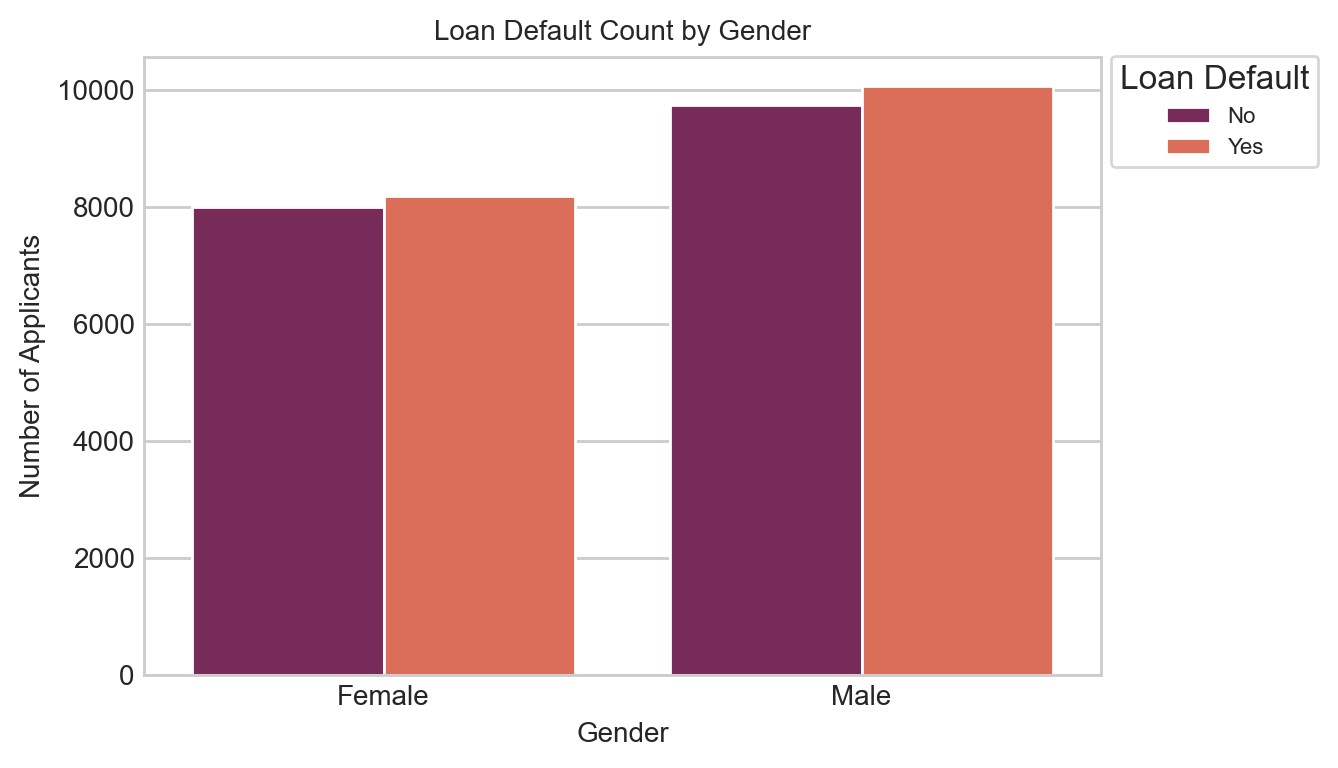

In [691]:
# Set the figure size for the plot
plt.figure(figsize=(7, 4), dpi=200)
sns.set_style('whitegrid')

# Create a count plot showing the number of applicants by gender,
# further separated by whether they had previous loan defaults
sns.countplot(
    x='person_gender',
    hue='previous_loan_defaults_on_file',       # Hue: Split by previous loan default status
    data=eda_df,                              
    palette='rocket'                          
)

# Add a title and axis labels
plt.title('Loan Default Count by Gender', fontsize=10)
plt.xlabel('Gender', fontsize=10)
plt.ylabel('Number of Applicants', fontsize=10)

# Customize the ticks
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], fontsize=10)
plt.yticks(fontsize=10)

# Customize the legend
plt.legend(
    title='Loan Default',                       # Title of the legend
    frameon=True,                               # Draw a box around the legend
    loc='upper right',                          # Anchor the legend to the upper right of the plot area
    bbox_to_anchor=[1.23, 1.005],                # Offset the legend position outside the plot
    borderaxespad=0.1,                          # Padding between the legend content and its border
    fontsize=8)

# Adjust plot layout to prevent overlap or clipping
plt.tight_layout()

# Display the final plot
plt.show()


From the visualization, we observe that the male gender had the highest propensity to default on loans compared to females. The males also had the highest number of applicants who didn't default on loans. This trent reflects that males consitute the highest proportion of applicants applying for loans which leads to higher count of males defaulting and not defaulting on loans. 

Another notable thing is that the proportion of applicants who had defaulted on a previous loan was higher compared to those who hadn't. 

Let's perform a chi-square statistical test to test whether loan default status is dependent on gender.

> **Alternate Hypothesis** - The loan default status is dependent on gender
>
> **Null Hypothesis** - The loan default status is independent of the gender

In [683]:
# Create a contingency table 
contingency = pd.crosstab(encoded_df['person_gender'], encoded_df['previous_loan_defaults_on_file'])

# Perform the Chi-Square test of independence on the contingency table
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

# Print the p-value from the test to assess statistical significance
if p_value < 0.05:
    print('Reject Null Hypothesis - The loan default status is dependent on gender')
else:
    print('Fail to Reject Null Hypothesis -  The loan default status is independent of gender')
print(f"P_value: {p_value:.3f}")


Fail to Reject Null Hypothesis -  The loan default status is independent of gender
P_value: 0.676


The statistical test has a p_value of 0.676 which greatly exceeds our significance level. We can conclude from this that the loan defaulting status is affected by gender.

Next, let's delve into the **age of the applicants** and how it affects the loan defaulting status. The aim of this is to analyze whether certain ge groups may be more or less likely to default. This can help financial institutions tailor loan terms and approvals by age group.

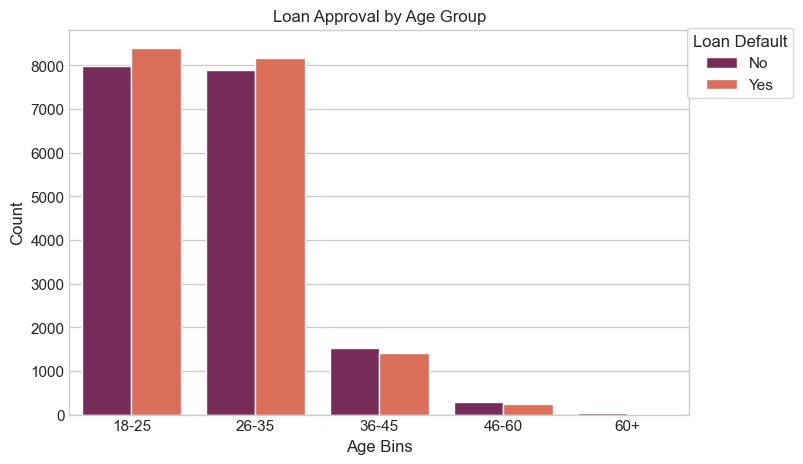

In [720]:
# Create age bins by segmenting 'person_age' into specified ranges with labels
eda_df['age_bin'] = pd.cut(
    eda_df['person_age'],                  # The age column to bin
    bins=[18, 25, 35, 45, 60, 100],       # Define age intervals (bins)
    labels=['18-25', '26-35', '36-45', '46-60', '60+']  # Labels for each bin
)

# Set the figure size for the plot
plt.figure(figsize=(8, 5))

sns.set_style('whitegrid')

# Create a count plot showing the number of applicants per age group,
# separated by their previous loan default status
sns.countplot(
    x='age_bin',                          # Use the binned age groups on the x-axis
    hue='previous_loan_defaults_on_file', 
    data=eda_df,               
    palette='rocket'       
)

# Add a title to the plot
plt.title('Loan Approval by Age Group')
plt.xlabel('Age Bins')
plt.ylabel('Count')

# Customize the legend appearance and location
plt.legend(
    title='Loan Default',
    frameon=True,  
    loc='upper right',                  # Position the legend in the upper right corner
    bbox_to_anchor=[1.18,1.024]
)


From this visualization, it is observed that the  18 - 25 age range has the most loan defaults followed closely by the 26 - 35 age range. The age range of 36 - 45, the number of applicants without loan defaults exceeds those who defaulted, indicating a shift toward more responsible repayment behavior. Beyond the age of 45, loan applications drop sharply, with significantly fewer individuals applying for or receiving loans. Notably, the 60+ age group has minimal loan activity, suggesting that older individuals are either less likely to apply for loans or are less frequently approved.

Next, let's test whether there is a statistically significant difference between the average age of people who have defaulted on loans before and those who haven’t. This helps assess if age is a predictor or associated factor for previous defaults.

> **Alternate Hypothesis** - There is a difference in the mean age between the two groups.
> 
> **Null hypothesis** - There is no difference in the mean age of individuals with previous loan defaults and those without.

In [728]:
# Split data into two groups based on loan default history
no_default = eda_df[eda_df['previous_loan_defaults_on_file'] == 'No']['person_age']
default = eda_df[eda_df['previous_loan_defaults_on_file'] == 'Yes']['person_age']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(no_default, default, equal_var=False)  # Welch's t-test is safer if variances are unequal

# Interpretation
if p_value < 0.05:
    print('Reject Null Hypothesis - There is a difference in the mean age between the two groups.')
else:
    print('Fail to Reject Null Hypothesis -There is no difference in the mean age of individuals with previous loan defaults and those without.')
print(f'P-value: {p_value:.4f}')

Reject Null Hypothesis - There is a difference in the mean age between the two groups.
P-value: 0.0000


The age feature has a p-value of 0.00 meaning that there is **a statistical significant difference** between the average age of people who have defaulted on loans before and those who haven’t.

The final part in addressing this objective involves analyzing the relationship between a person's education level and their loan status using a stacked bar chart. This helps identify how loan approval or default varies across different education categories.

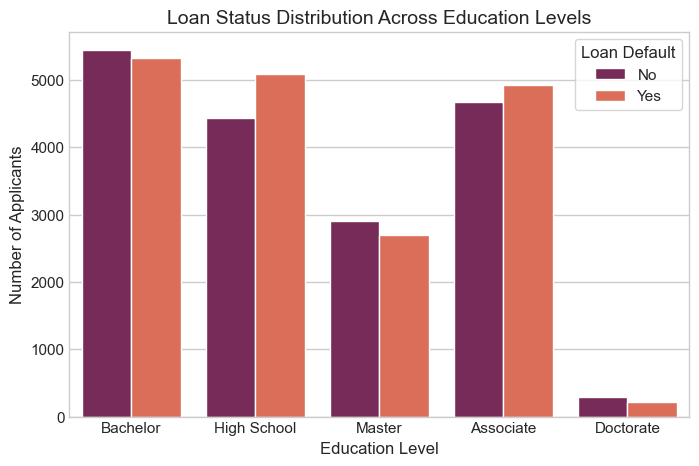

In [734]:
# Set the visual style for the seaborn plots
sns.set_style('whitegrid')

# Create a countplot showing counts of loan default status for each education level
plt.figure(figsize=(8, 5))
sns.countplot(
    data=eda_df,                               # Data source
    x='person_education',                      # X-axis: education level categories
    hue='previous_loan_defaults_on_file',     # Hue: loan default status to split counts by this variable
    palette='rocket'                           # Color palette for the different loan default statuses
)

# Add title and axis labels
plt.title('Loan Status Distribution Across Education Levels', fontsize=14)
plt.xlabel('Education Level')
plt.ylabel('Number of Applicants')

# Add legend with a title and location
plt.legend(title='Loan Default', frameon=True, loc='upper right')

# Show the plot
plt.show()

From this visualization it can be observed that the Bachelor's degree holdershave the highest number of loan applicants, with a slightly higher number of defaults compared to those without defaults. Majority of those with only high school qualifications loan defaults compared to those who don't, similar to those with Assiciate qualifications. Doctorate holders are the fewest in number, and their defaults are minimal suggesting lower risk.

Loan default rates are relatively high across most education levels, especially in Bachelor’s, Associate, High School, indicating that higher education does not necessarily reduce the likelihood of defaulting. However, extremely low defaults among Doctorate holders may imply better creditworthiness.

Next, let's determine whether there is a statistically significant association between a person's education level and their previous loan default status.

> **Alternative hypothesis** : There is an association between education level and loan default status.
>
>**Null hypothesis**: Education level and loan default status are independent.


In [739]:
# Create a contingency table (cross-tabulation) between education and loan default status
contingency = pd.crosstab(
    encoded_df['person_education'],          # Rows: education levels (encoded)
    encoded_df['previous_loan_defaults_on_file']  # Columns: loan default status (encoded)
)

# Perform Chi-square test of independence on the contingency table
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

# Interpretation
if p_value < 0.05:
    print('Reject Null Hypothesis - There is an association between education level and loan default status.')
else:
    print('Fail to Reject Null Hypothesis -  Education level and loan default status are independent.')
print(f'P-value: {p_value:.3f}')

Reject Null Hypothesis - There is an association between education level and loan default status.
P-value: 0.000


###  Objective 2: Determine whether there is a statistically significant relationship between an applicant's credit score and their loan approval status.

This objective seeks to find out if an applicant’s credit score influences whether their loan application gets approved or not.

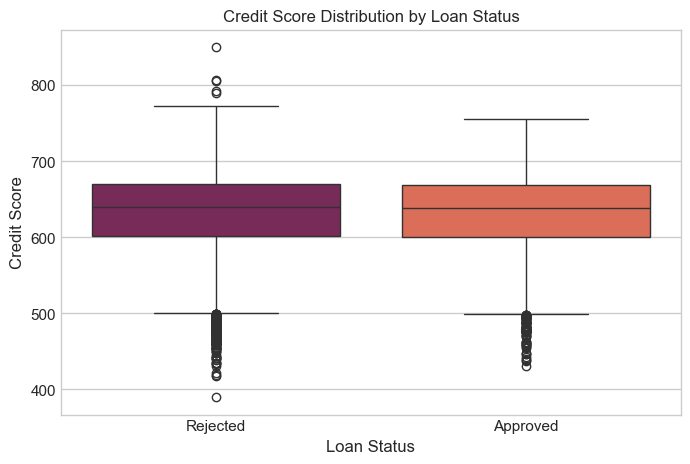

In [740]:
# Set the figure size to 8 inches wide and 5 inches tall
plt.figure(figsize=(8, 5))

# Set the visual style for seaborn plots to 'whitegrid' for better readability
sns.set_style('whitegrid')

# Create a boxplot to show the distribution of credit scores for each loan status category
sns.boxplot(
    x='Loan_Status_Encoded',   # Categorical variable on the x-axis (loan status encoded)
    y='credit_score',          # Numerical variable on the y-axis (credit scores)
    data=eda_df,               # Data source DataFrame
    palette='rocket'           # Color palette for the boxplot
)

# Add a title to the plot
plt.title('Credit Score Distribution by Loan Status')

# Label the x-axis
plt.xlabel('Loan Status')

# Label the y-axis
plt.ylabel(title'Credit Score')

# Display the plot
plt.show()

The median credit score and interquartile ranges of these two categories are nearly indentical and lie aroung the 650 mark. However, it can be observed that the rejected group had some applicants with high credit scores that had their application rejected. 

Let's plot the distribution plots of these two categories to better pick up on the nuances.

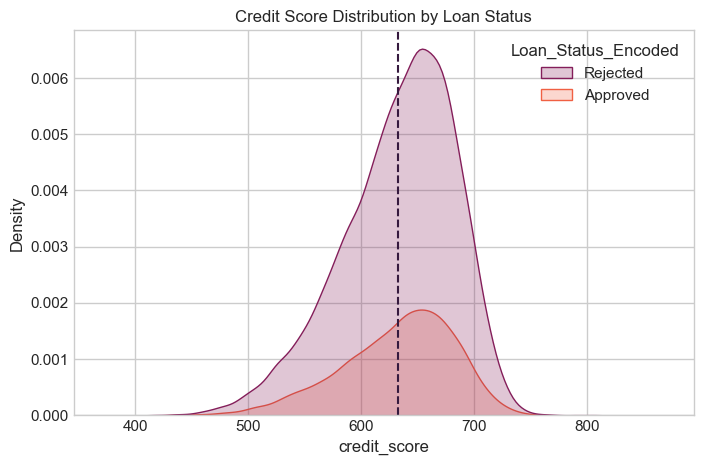

In [754]:
# Set the figure size for the plot
plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')

# Create a KDE plot (Kernel Density Estimate) to show the distribution of credit scores

sns.kdeplot(x='credit_score', 
            hue='Loan_Status_Encoded',  # separate the plot by Loan Status
            data=eda_df,
            fill=True, 
            palette='rocket')

# Add a line for the mean
plt.axvline(eda_df['credit_score'].mean(), linestyle='--')

# Add a title to the plot
plt.title('Credit Score Distribution by Loan Status')

# Display the plot
plt.show()

Both groups have peaks around 650. The curves also overlap with borrowers with 'good' credit scores still get rejected while their similar counterparts are approved. This shows that this is not a reliable feature for predicting whether an applicant will get approved or rejected. Let's perform a statistical test to analyze whether there is a statistical sinificance between the two groups.

> Alternative Hypothesis - There is a significant difference in the mean credit scores between approved and rejected applicants.
>
> Null Hypothesis - There is no difference in the mean credit scores of approved and rejected loan applicants.

In [756]:
# Filter credit scores for approved loan applicants
approved = eda_df[eda_df['Loan_Status_Encoded'] == 'Approved']['credit_score']

# Filter credit scores for rejected loan applicants
rejected = eda_df[eda_df['Loan_Status_Encoded'] == 'Rejected']['credit_score']

# Perform an independent two-sample t-test assuming unequal variances (Welch's t-test)
t_stat, p_value = stats.ttest_ind(approved, rejected, equal_var=False)

# Display the p-value with 3 decimal places
if p_value < 0.05:
    print('Reject Null Hypothesis - There is a significant difference in the mean credit scores between approved and rejected applicants.')
else:
    print('Fail to Reject Null Hypothesis - There is no difference in the mean credit scores of approved and rejected loan applicants.')
print(f"P-value: {p_value:.3f}")

Fail to Reject Null Hypothesis - There is no difference in the mean credit scores of approved and rejected loan applicants.
P-value: 0.218


## Feature Selection

The aim of this section is to identify and retaion only the features in the dataset that constribute to the outcome of the target variable. This will help improve model performance by focusing only on the relevant columns. This will also  reduce overfitting by eliminating noise.

To begin, let's create a function that takes two parameters; a dataframe and a threshold to be used to filter features with a correlation with the target variable lower than its value.

In [764]:
def feature_selection(df, threshold=0.2):

    target_col = 'loan_status'

    # Compute correlations with the target
    correlation = df.corr()[target_col].drop(target_col)

    # Filter features based on absolute correlation threshold
    selected_features = correlation[correlation.abs() >= threshold].index.tolist()

    # Return filtered DataFrame with selected features and the target
    return df[selected_features + [target_col]]


Let's apply the function to the training df to filter out columns with low correlation with the target variable.

In [769]:
# Apply the function to the training dataframe
final_df = feature_selection(num_df)
# Check the columns left
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 25180 to 15795
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   person_income                       36000 non-null  float64
 1   loan_amnt                           36000 non-null  float64
 2   loan_int_rate                       36000 non-null  float64
 3   loan_percent_income                 36000 non-null  float64
 4   person_home_ownership_OWN           36000 non-null  float64
 5   person_home_ownership_RENT          36000 non-null  float64
 6   loan_intent_EDUCATION               36000 non-null  float64
 7   loan_intent_MEDICAL                 36000 non-null  float64
 8   loan_intent_VENTURE                 36000 non-null  float64
 9   previous_loan_defaults_on_file_Yes  36000 non-null  float64
 10  loan_status                         36000 non-null  float64
dtypes: float64(11)
memory usage: 4.3 MB


Three columns that had a correlation less than 0.2 have been filtered leaving a total of 9 column excluding the target variable from the original 14 columns. The dataset is now ready for modelling

## Modelling

In this section, we will develop and evaluate three models to accurately predict whether the applicant will have their loan approved or rejected. The models will be validated using the test data and the model with the highest accuracy score will be chosen
The models to be used are:
* Logistic Regression
* Decision Trees
* XGBoost

The models will be evaluated using the **F1-Score** which provides a balanced measureof both precision and recall. This is important because in loan approval to not only minimise false positives (approving loans to risky applicants) but also avoid false negatives (rejecting creditworthy applicants). The F1-score is particularly useful in cases of class imbalance, where one outcome occurs more frequently than the other.

### Data Preparation

In [865]:
scaled_test = apply_scaler_on_test(test_df, scaler)
encoded_test = encode_df(scaled_test)
selected_df = feature_selection(encoded_test)
X_test = drop_columns(selected_df)
X_test.drop('loan_status', axis=1, inplace=True)
y_test = encoded_test['loan_status']

X_train = final_df.drop('loan_status', axis=1)
y_train = num_df['loan_status']

Now that we have the final dataset for modelling, let's check for class imbalance in the target variable.

In [866]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 25180 to 15795
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   person_income                       36000 non-null  float64
 1   loan_amnt                           36000 non-null  float64
 2   loan_int_rate                       36000 non-null  float64
 3   loan_percent_income                 36000 non-null  float64
 4   person_home_ownership_OWN           36000 non-null  float64
 5   person_home_ownership_RENT          36000 non-null  float64
 6   loan_intent_EDUCATION               36000 non-null  float64
 7   loan_intent_MEDICAL                 36000 non-null  float64
 8   loan_intent_VENTURE                 36000 non-null  float64
 9   previous_loan_defaults_on_file_Yes  36000 non-null  float64
dtypes: float64(10)
memory usage: 4.0 MB


In [867]:
# Check for class imbalance
y_train.value_counts()

loan_status
0.0    28010
1.0     7990
Name: count, dtype: int64

The rejected category has four times more data compared to the approved category. To combat thos, let's resample the data tomake it more inclusive for all categories. The best way to do this is by using **SMOTE**.

In [881]:
# Insantiate SMOTE and set the minority class to have 27000 records
smote = SMOTE(random_state=42, sampling_strategy = {1: 25000})
# Fit SMOTE to the training dataset
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# Verify the results
y_resampled.value_counts()

loan_status
0.0    28010
1.0    25000
Name: count, dtype: int64

### 1. Logistic Regression (Baseline Model)

This will act as the baseline model in order to provide a simple benchmark out of which all other models can be compared and also set the expectations on the performance.

Let's begin modelling. To start, let's instantiate a Logistic Regression model and fit it to the resampled data.

In [947]:
# Instantiate the model
logreg = LogisticRegression(solver='liblinear', fit_intercept=False)
# Fit it to the resampled data
logreg.fit(X_resampled, y_resampled)

LogisticRegression(fit_intercept=False, solver='liblinear')

To better view the results, a function will be created that outputs the model's classification report (F1 Score, recall, precision and accuracy) together with the confusion matrix and the ROC curve.

In [1029]:
# Create a model that outputs the classification report, confusion matrix, ROC curve and the AUC score
def evaluate_model(model, X, y_true, model_name='Model'):
    
    # Set labels
    class_labels=['Rejected', 'Approved']
    
    # Predict labels
    y_pred = model.predict(X)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    disp.plot(ax=ax, cmap='Reds')
    ax.grid(False)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Compute ROC curve and AUC
    if model_name in ['XGBoost', 'Decision Tree'] :
        y_scores = model.predict_proba(X)[:, 1]
    else:
        y_scores = model.decision_function(X)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(6, 5))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right', frameon=True, bbox_to_anchor=[1.015,-0.02])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print('-------------- Classification Report --------------\n')
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print('\n-------------- AUC Score --------------\n')
    print(f'AUC Score: {roc_auc:.4f}')

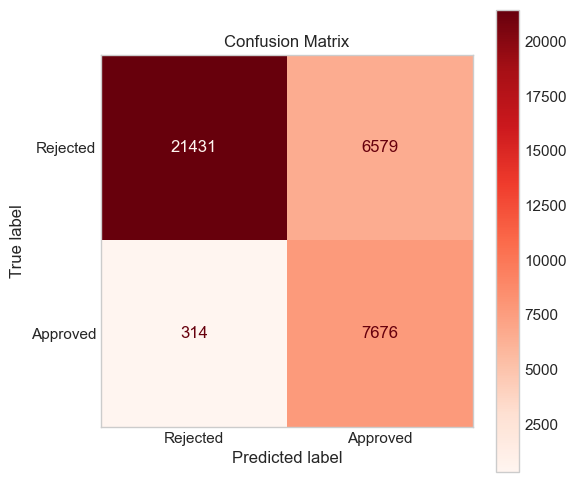

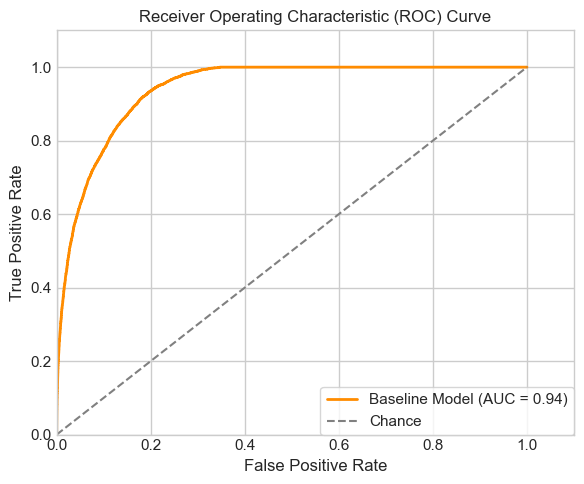

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.99      0.77      0.86     28010
    Approved       0.54      0.96      0.69      7990

    accuracy                           0.81     36000
   macro avg       0.76      0.86      0.78     36000
weighted avg       0.89      0.81      0.82     36000


-------------- AUC Score --------------

AUC Score: 0.9411


In [1004]:
# Apply the function to evalaute the model and get the scores
evaluate_model(logreg, X_train, y_train, model_name='Baseline Model')

The model has a 81 % prediction accuracy. The f1 score is 86% for rejected data and 69% for approved data.

Let's now validate the model on the unseen test data. A significantly lower performance compared to the training set would indicate potential overfitting.

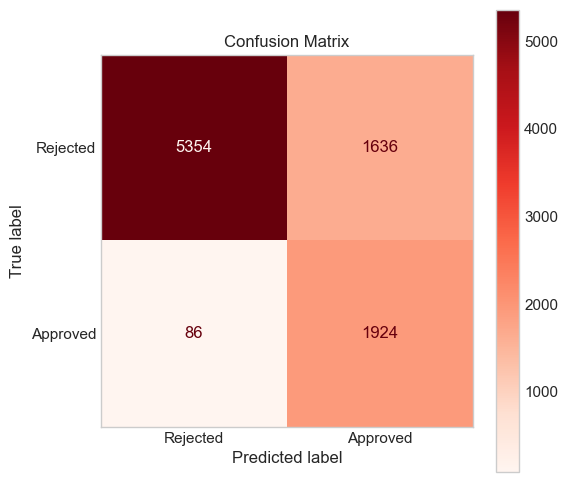

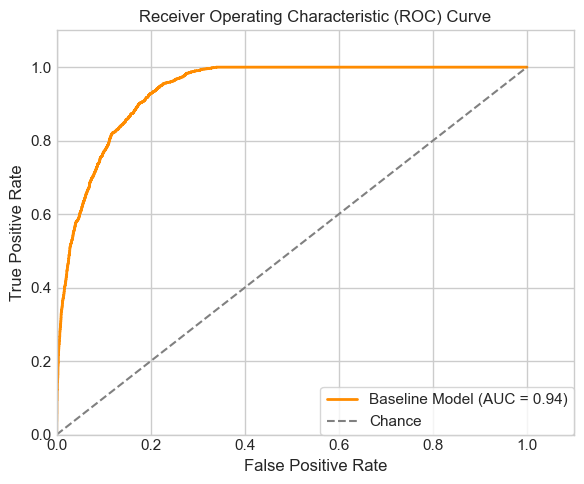

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.98      0.77      0.86      6990
    Approved       0.54      0.96      0.69      2010

    accuracy                           0.81      9000
   macro avg       0.76      0.86      0.78      9000
weighted avg       0.89      0.81      0.82      9000


-------------- AUC Score --------------

AUC Score: 0.9388


In [950]:
# Validate the model using the test data
evaluate_model(logreg,X_test, y_test, model_name='Baseline Model')

### Model Results

The model performs similarly for both the training  and testing data. This is a good sign as it means there is no overfitting. However, the model perfored poorly when predicting the rejected applications. This led to a high number of false positive predictions which drove the precision score to 54% and ultimately driving down the f1-score to 69%. A likely contributing factor is the oversampling. The oversampling introduced too many duplicated instances of approved applications causing the model to become biased towards predicting approvals. This made it hard for the model to correctly recognize patterns associated with rejected applications. 

To address this, the step will be to fine tune the logistic regression model by using different **class weights** that will penalizing misclassification of rejected applications more heavily.

### Logistic Regression Fine Tuning

One of the insights we got from the data preparation was that there was some multicollinearity between some of the features. To address this, we'll apply **L1 regularization (Lasso)**, which helps by shrinking less important feature coefficients to zero—effectively performing feature selection. 

Let's explore the different class weights and how much they impact the overall model performance.

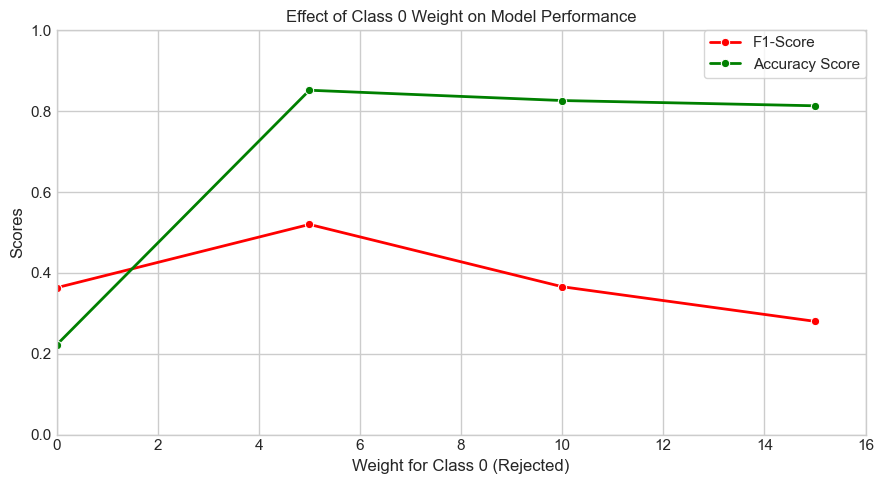

In [991]:
# Define the range of weights to test for class 0 (rejected applications)
class_0_weights = np.arange(0, 20, 5)

# Lists to store evaluation results for each weight setting
accuracy_scores = []
f1_scores = []
weight_labels = []

# Loop through each weight for class 0
for w0 in class_0_weights:
    weights = {0: w0, 1: 1}  # Fix weight of class 1 (approved) at 1, vary weight of class 0

    # Train logistic regression model with L1 penalty and specified class weights
    model = LogisticRegression(solver='liblinear', penalty='l1', class_weight=weights)
    model.fit(X_train, y_train)

    # Predict on training data
    y_pred = model.predict(X_train)

    # Evaluate performance using F1-score and accuracy
    f1 = f1_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)

    # Store results for plotting
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    weight_labels.append(w0)

# Plot the effect of class 0 weight on model performance
plt.figure(figsize=(9, 5))  # Set figure size

# Plot F1-scores
sns.lineplot(x=weight_labels, y=f1_scores, marker='o', linewidth=2, color='red', label='F1-Score')

# Plot Accuracy scores
sns.lineplot(x=weight_labels, y=accuracy_scores, marker='o', linewidth=2, color='green', label='Accuracy Score')

# Set plot labels and formatting
plt.xlabel('Weight for Class 0 (Rejected)')
plt.ylabel('Scores')
plt.xlim([0, 16]) 
plt.ylim([0, 1])

# Add a title and grid
plt.title('Effect of Class 0 Weight on Model Performance')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(frameon=True, bbox_to_anchor=[1.01, 1.02])

# Show the plot
plt.show()

From the plot above, the model performed worse in terms of f1-score than before when using class weights to penalize majority class. When accuracy reached a high of 85%, f1-score peaked at 52%. This goes to show that the previous model was better at making predictions. Next, let's create a model and employ **GridSearchCV** to tune the hyperparameters and find the best parameter combinations.

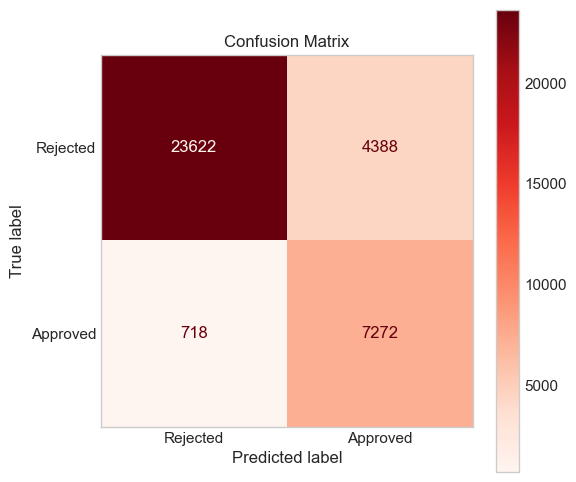

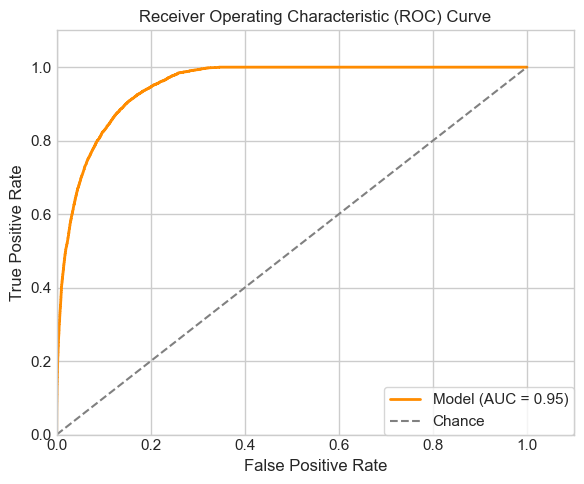

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.97      0.84      0.90     28010
    Approved       0.62      0.91      0.74      7990

    accuracy                           0.86     36000
   macro avg       0.80      0.88      0.82     36000
weighted avg       0.89      0.86      0.87     36000


-------------- AUC Score --------------

AUC Score: 0.9509


In [966]:
tuned_model = LogisticRegression(solver='liblinear', penalty='l1')
tuned_model.fit(X_resampled, y_resampled)
evaluate_model(tuned_model, X_train, y_train)

In [997]:
# List the parameters to be tested
parameters = {
    'solver': ['liblinear'],           # supports l1 lenalty
    'penalty': ['l1'],                 # apply a penalty to combat multicollinearity
    'fit_intercept': [True, False],    # Drop False if not critical to test
    'C': [0.5, 1e12]                           # Drop extremes (0.0001, 10)
}

grid_logreg = GridSearchCV(logreg, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_resampled, y_resampled)

GridSearchCV(cv=5,
             estimator=LogisticRegression(fit_intercept=False,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.5, 1000000000000.0],
                         'fit_intercept': [True, False], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             scoring='accuracy')

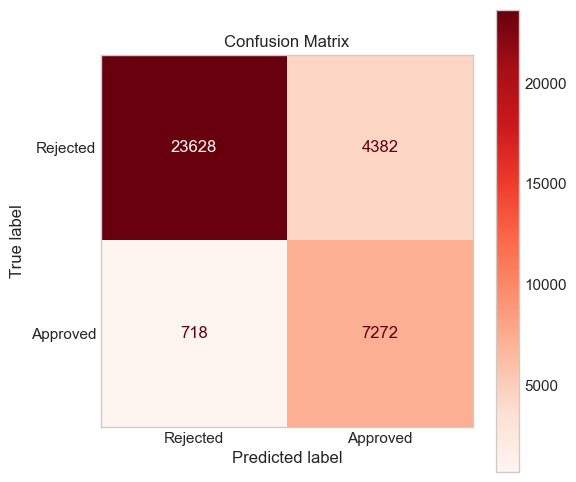

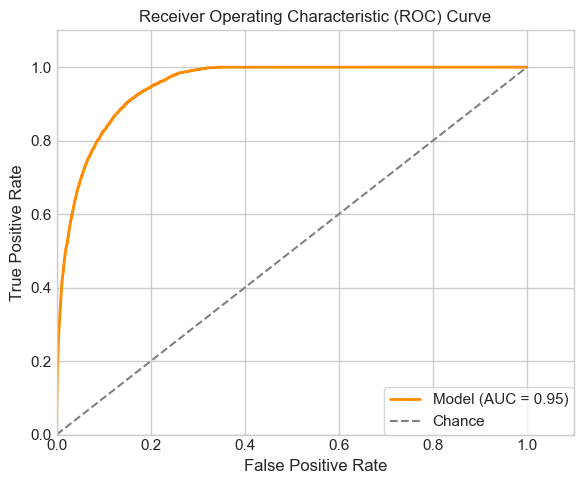

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.97      0.84      0.90     28010
    Approved       0.62      0.91      0.74      7990

    accuracy                           0.86     36000
   macro avg       0.80      0.88      0.82     36000
weighted avg       0.89      0.86      0.87     36000


-------------- AUC Score --------------

AUC Score: 0.9509


In [998]:
evaluate_model(grid_logreg.best_estimator_,X_train, y_train)

After using **GridSearchCV** the model has performed better scoring 86% accuracy and 74% f1 score for the approved class. The model also had an **AUC Score** of 95% . Next let's validate the tuned model on the test data.

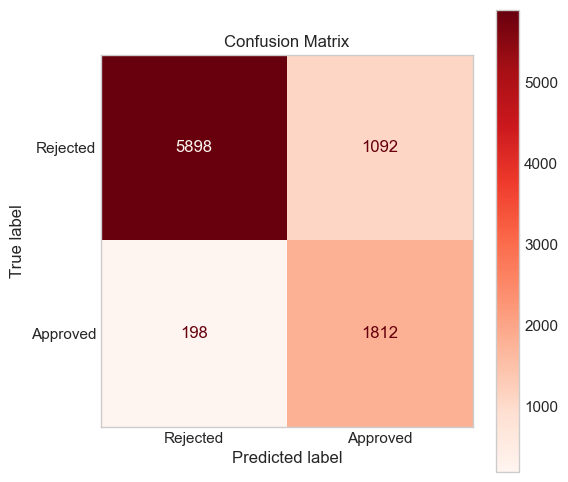

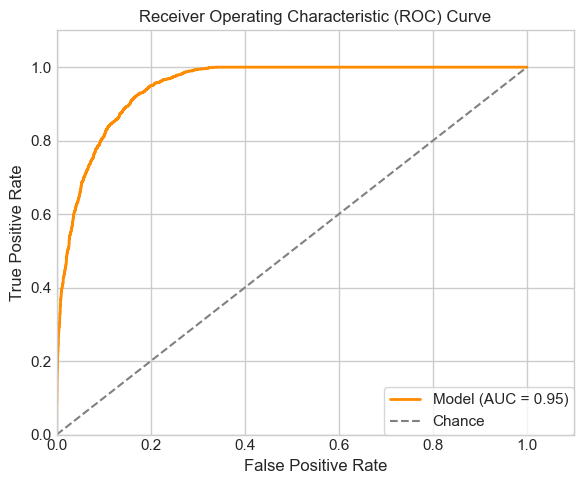

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.97      0.84      0.90      6990
    Approved       0.62      0.90      0.74      2010

    accuracy                           0.86      9000
   macro avg       0.80      0.87      0.82      9000
weighted avg       0.89      0.86      0.86      9000


-------------- AUC Score --------------

AUC Score: 0.9480


In [999]:
evaluate_model(grid_logreg.best_estimator_,X_test, y_test)

The test data scored garnered scores similar to the test data apart from the AUC Score which dropped very slightly to 94.8%.This shows that there is no overfitting and the model is very well generalized.

### 2. Decision Tree

In [1035]:
tree = DecisionTreeClassifier(random_state=42)
parameters = {
    'criterion': ['entropy', 'gini'],          # Splitting criteria
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],           # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples needed in a leaf node
    'max_leaf_nodes': [None, 10, 20, 30]
}

grid_tree = GridSearchCV(tree, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [3, 5],
                         'max_leaf_nodes': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

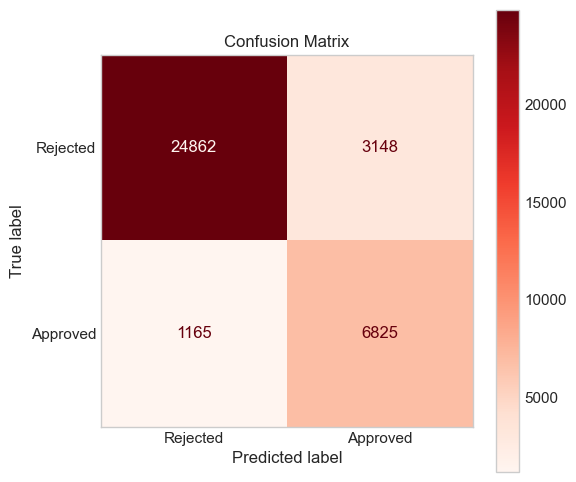

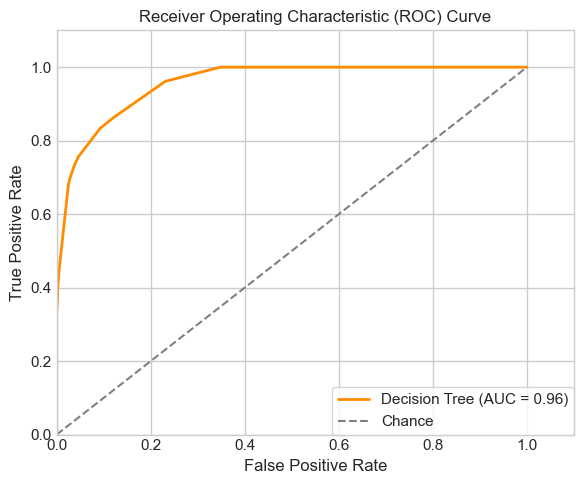

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.96      0.89      0.92     28010
    Approved       0.68      0.85      0.76      7990

    accuracy                           0.88     36000
   macro avg       0.82      0.87      0.84     36000
weighted avg       0.90      0.88      0.88     36000


-------------- AUC Score --------------

AUC Score: 0.9566


In [1037]:
evaluate_model(grid_tree.best_estimator_, X_train, y_train, model_name='Decision Tree')

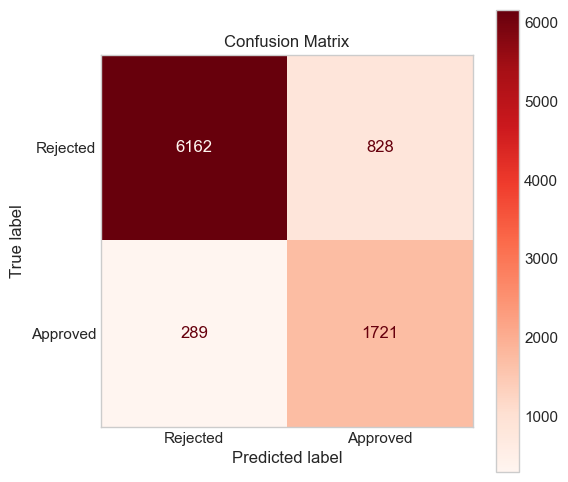

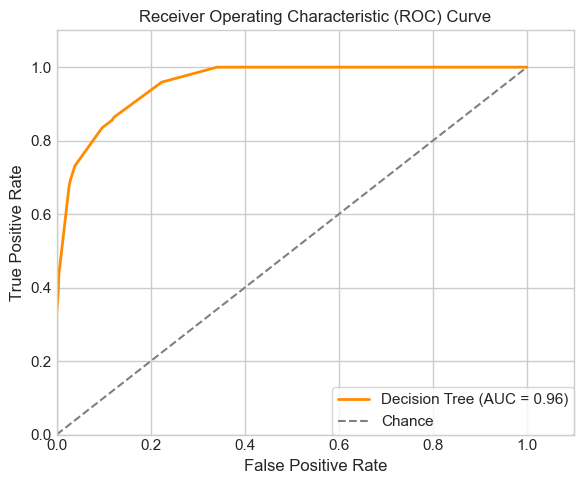

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.96      0.88      0.92      6990
    Approved       0.68      0.86      0.75      2010

    accuracy                           0.88      9000
   macro avg       0.82      0.87      0.84      9000
weighted avg       0.89      0.88      0.88      9000


-------------- AUC Score --------------

AUC Score: 0.9560


In [1038]:
evaluate_model(grid_tree.best_estimator_, X_test, y_test, model_name='Decision Tree')

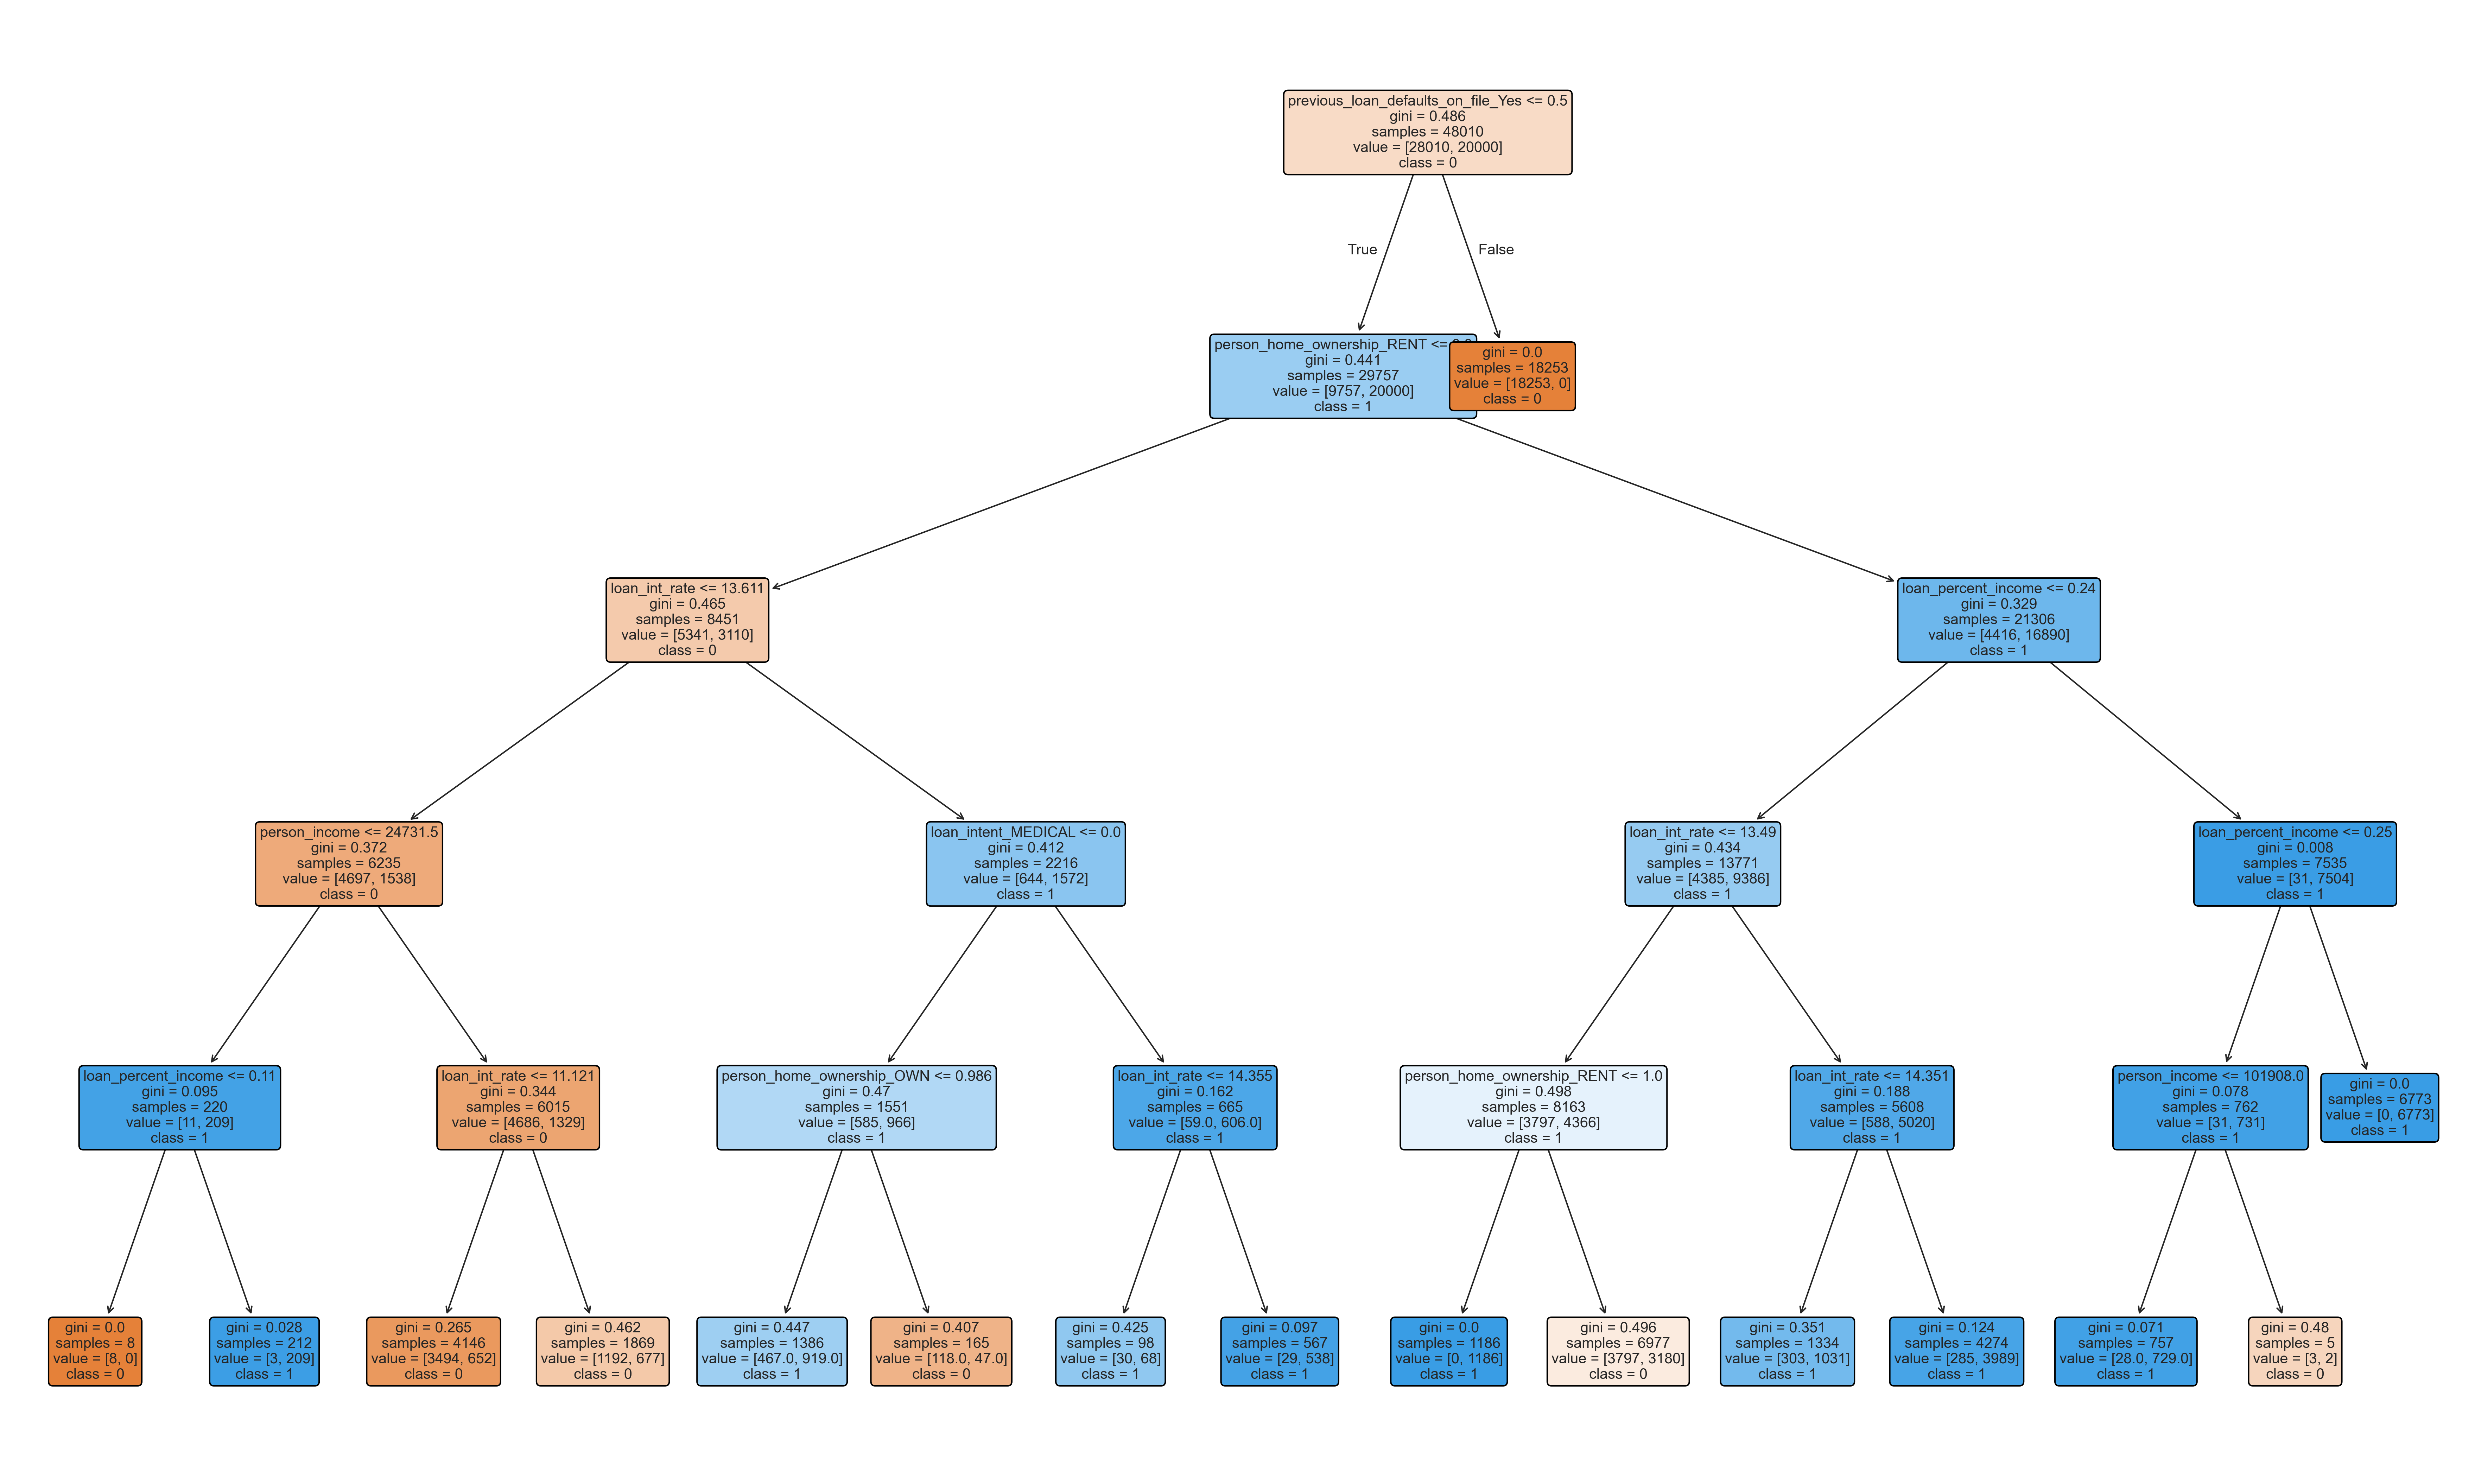

In [71]:
plt.figure(figsize=(30, 18), dpi=300)
plot_tree(grid_tree.best_estimator_, filled=True, feature_names=X_train.columns.to_list()
          , class_names=['0','1'], rounded=True,
          fontsize=10)
plt.show()

### 3. XGBoost

In [1024]:
boost = XGBClassifier()


boost.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

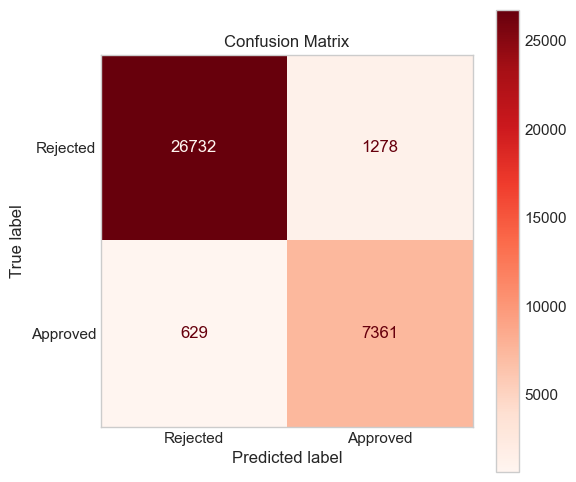

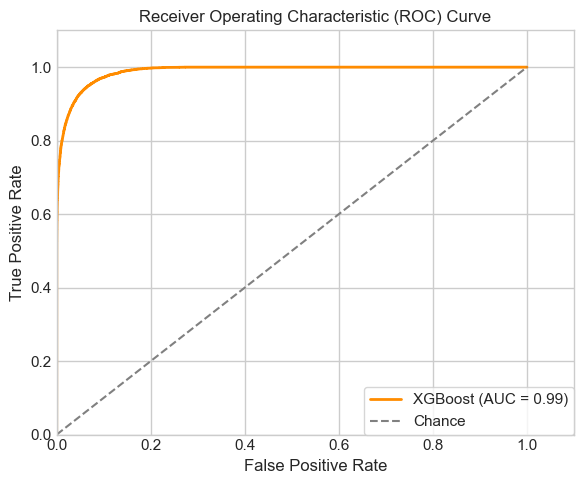

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.98      0.95      0.97     28010
    Approved       0.85      0.92      0.89      7990

    accuracy                           0.95     36000
   macro avg       0.91      0.94      0.93     36000
weighted avg       0.95      0.95      0.95     36000


-------------- AUC Score --------------

AUC Score: 0.9887


In [1025]:
evaluate_model(boost, X_train, y_train, model_name='XGBoost')

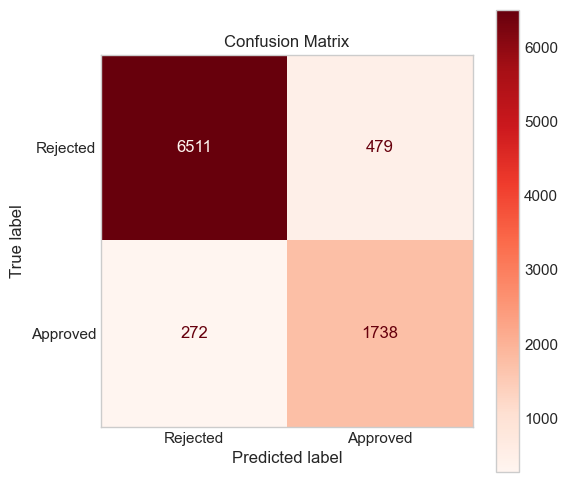

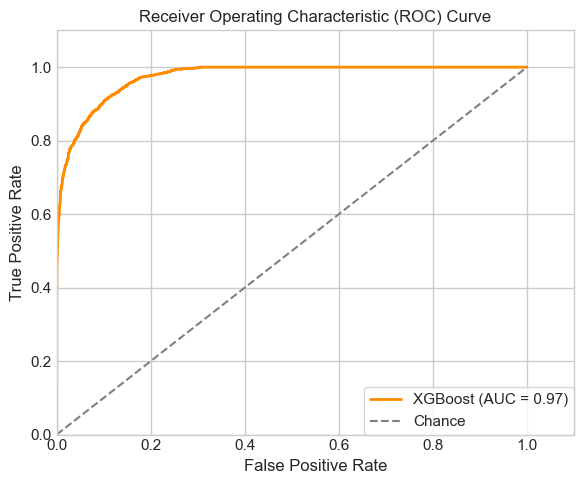

-------------- Classification Report --------------

              precision    recall  f1-score   support

    Rejected       0.96      0.93      0.95      6990
    Approved       0.78      0.86      0.82      2010

    accuracy                           0.92      9000
   macro avg       0.87      0.90      0.88      9000
weighted avg       0.92      0.92      0.92      9000


-------------- AUC Score --------------

AUC Score: 0.9739


In [1026]:
evaluate_model(boost, X_test, y_test, model_name='XGBoost')